In [1]:
import os
import glob
import time

import pandas as pd
import numpy as np
import xarray as xr
from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

import metpy.calc as mpcalc
from metpy.cbook import get_test_data
from metpy.plots import add_metpy_logo, SkewT
from metpy.units import units

import cartopy.crs as ccrs
import cartopy

import sys
p = os.path.abspath('../')
if p not in sys.path:
    sys.path.append(p)
from orographicPrecipitation.precip_model_functions import retrieve_era5_pl,retrieve_era5_sfc

ERA5M_PATH  = "/global/homes/w/wboos/m3310project/wboos/era5monthlyQuentin/"
ERA5M_PATH2 = "/global/project/projectdirs/m3310/wboos/era5monthly/"

# Masks

In [2]:
boxNH = [[-100, -70, 12 , 20],
         [-80 , -60, 8  , 16],
         [70  , 90 , 2  , 18],
         [100 , 120, 8  , 20],
         [118 , 140, 4  , 20],
         [100 , 110, 0  , 12],
        ]

boxSH = [[20  , 50 , -20, 0 ],
         [-60 , -30, -20, 0 ],
        ]

boxNH1 = [[b[0]%360,b[1]%360,b[2],b[3]] for b in boxNH]
boxSH1 = [[b[0]%360,b[1]%360,b[2],b[3]] for b in boxSH]

namesNH = ["Central America",
           "Venezuela",
           "South India / Sri Lanka",
           "Vietnam / South China Sea",
           "Philippines",
           "Malaysia"
          ]
namesSH = ["Tanzania",
           "NorthEast Brazil"
          ]

In [4]:
def slide_coord(mask):
    """Switch the longitude coord from (-180,180) to (0,360) 
    and change coordinate names from 'LAT1','LON1' to 'latitude' and 'longitude'"""
    mask0=mask.copy()
    mask0.coords['longitude'] = mask0.coords['LON1']%360
    mask1 = mask0.swap_dims({'LON1': 'longitude'}).rename({'LAT1': 'latitude'})

    #Sort the longitude values
    sort_inds = {"longitude": np.argsort(mask1["longitude"].values)}
    mask1 = mask1.isel(**sort_inds)
    return mask1

#masks = xr.open_dataset("/global/cscratch1/sd/qnicolas/masks/winter_rainfall_masks.nc")
#/!\ temporary change for access on Spin
masks = xr.open_dataset("winter_rainfall_masks.nc")
trmm_nh_winter_mask = masks.TRMM_NH_WINTER_MASK.fillna(0.)
trmm_sh_winter_mask = masks.TRMM_SH_WINTER_MASK.fillna(0.)

REFERENCE_GRID = xr.open_dataset(ERA5M_PATH+"e5.moda.an.sfc/e5.moda.an.sfc.128_134_sp.ll025sc.2018010100_2018120100.nc").SP.sel(latitude=slice(50., -50.)).isel(time=0) #to get the era5 grid

trmm_nh_winter_mask1 = (slide_coord(trmm_nh_winter_mask).interp_like(REFERENCE_GRID) > 0)*1.
trmm_sh_winter_mask1 = (slide_coord(trmm_sh_winter_mask).interp_like(REFERENCE_GRID) > 0)*1.
trmm_nh_winter_mask2 = slide_coord(trmm_nh_winter_mask)
trmm_sh_winter_mask2 = slide_coord(trmm_sh_winter_mask)                     

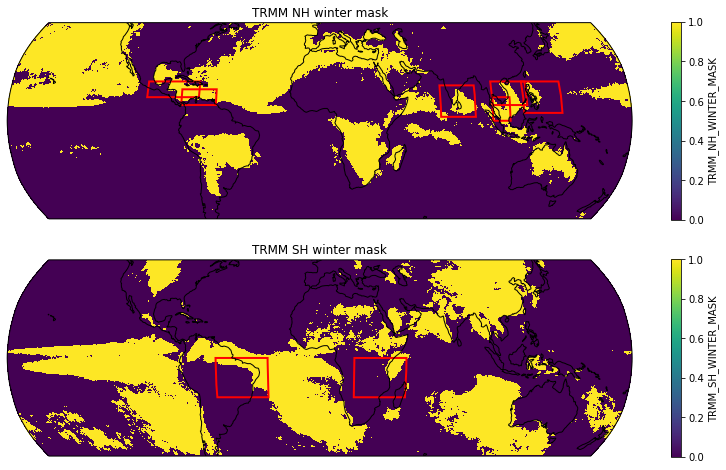

In [5]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(14,8),subplot_kw={'projection': ccrs.Robinson()})
trmm_nh_winter_mask1.plot(ax=ax1,transform=ccrs.PlateCarree())
trmm_sh_winter_mask1.plot(ax=ax2,transform=ccrs.PlateCarree())
ax1.coastlines();ax2.coastlines()
ax1.set_title("TRMM NH winter mask");ax2.set_title("TRMM SH winter mask")

for boxes,ax in [(boxNH1,ax1),(boxSH1,ax2)]:
    for i,b in enumerate(boxes):
        ax.add_patch(mpatches.Rectangle(xy=[b[0], b[2]], width=b[1]-b[0], height=b[3]-b[2],
                                        edgecolor='r',
                                        fill = False,
                                        lw=2,
                                        transform=ccrs.PlateCarree())
                     )


# Precipitation vs Vertically integrated moisture convergence

In [6]:
# Precipitation
all_pr = 1000*xr.open_dataset(ERA5M_PATH2+"era5_monthly_slev_1979-2019.nc").tp.interp_like(REFERENCE_GRID)
# Moisture convergence
all_mc = -3600*24*xr.concat([xr.open_dataset(file) for file in sorted(glob.glob(ERA5M_PATH2+"e5.mnth.mean.an.vinteg/*%s*.nc"%"162_084_viwvd"))],'time').VIWVD.sel(latitude=slice(50., -50.)).interp_like(REFERENCE_GRID)


In [7]:
def timesel(year,month,targetmonth,ly = 1979,uy = 2018):
    return (year >= ly) & (year <= uy) & (month == targetmonth)

mean_pr_nov = all_pr.sel(time = timesel(all_pr['time.year'],all_pr['time.month'],11)).mean("time")
mean_mc_nov = all_mc.sel(time = timesel(all_mc['time.year'],all_mc['time.month'],11,2008,2017)).mean("time")
mean_pr_may = all_pr.sel(time = timesel(all_pr['time.year'],all_pr['time.month'],5)).mean("time")
mean_mc_may = all_mc.sel(time = timesel(all_mc['time.year'],all_mc['time.month'],5,2008,2017)).mean("time")

/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Text(0.5, 1.0, 'MC May - 2008-2017 mean')

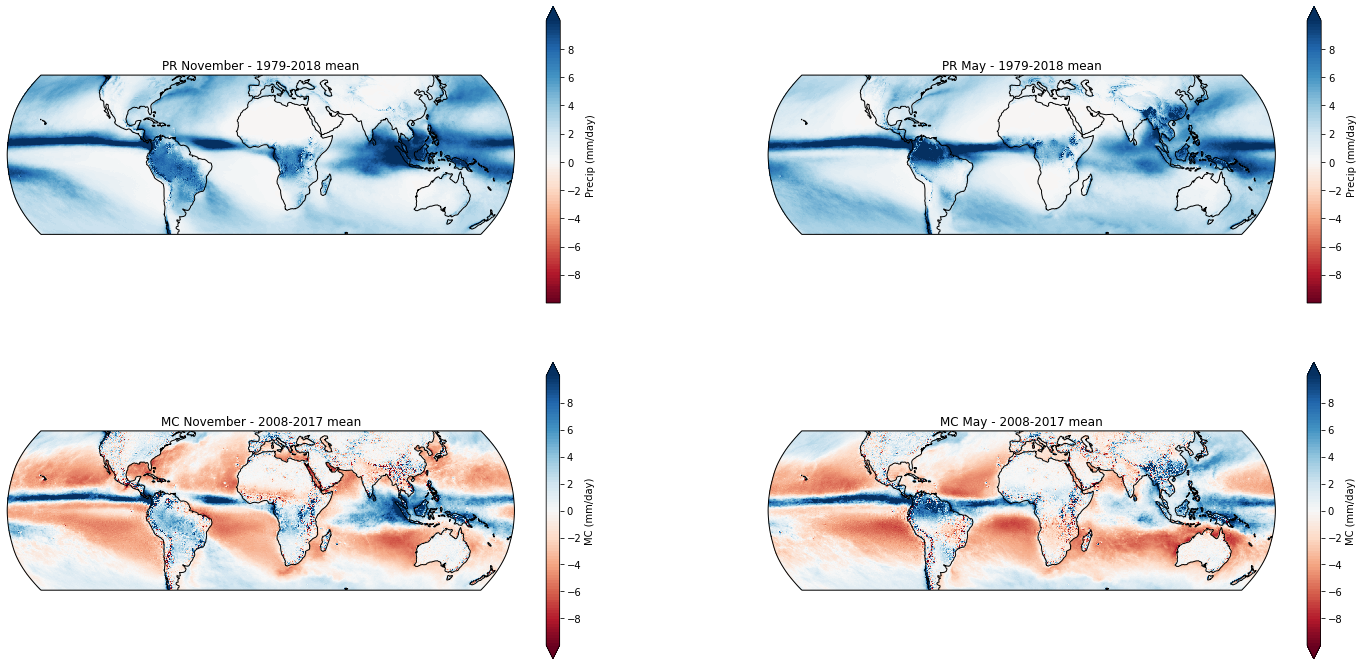

In [85]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(25,12),subplot_kw={'projection': ccrs.Robinson()})
mean_pr_nov.plot(ax=ax1,transform=ccrs.PlateCarree(),cmap=plt.cm.RdBu,cbar_kwargs={"label":"Precip (mm/day)","ticks":np.arange(-8.,10.,2.)},levels=np.linspace(-10.,10.,100))
mean_pr_may.plot(ax=ax2,transform=ccrs.PlateCarree(),cmap=plt.cm.RdBu,cbar_kwargs={"label":"Precip (mm/day)","ticks":np.arange(-8.,10.,2.)},levels=np.linspace(-10.,10.,100))
mean_mc_nov.plot(ax=ax3,transform=ccrs.PlateCarree(),cmap=plt.cm.RdBu,cbar_kwargs={"label":"MC (mm/day)","ticks":np.arange(-8.,10.,2.)},levels=np.linspace(-10.,10.,100))
mean_mc_may.plot(ax=ax4,transform=ccrs.PlateCarree(),cmap=plt.cm.RdBu,cbar_kwargs={"label":"MC (mm/day)","ticks":np.arange(-8.,10.,2.)},levels=np.linspace(-10.,10.,100))
ax1.coastlines();ax2.coastlines();ax3.coastlines();ax4.coastlines()
ax1.set_title("PR November - 1979-2018 mean");ax2.set_title("PR May - 1979-2018 mean")
ax3.set_title("MC November - 2008-2017 mean");ax4.set_title("MC May - 2008-2017 mean")

# Vertically integrated moisture convergence of the mean state, and its decomposition

In [11]:
#Data extraction from ERA5
era5yrs = list(range(1979,2019))

def retrieve_era5(year,varid):
    """gather an ERA5 monthly mean variable for the year 'year'
    varid gives the id of the variable in era5
        - year : str, "YYYY"
        - varid : str, eg. "128_130_t" for temperature
    """
    era5var = xr.open_dataset(glob.glob(os.path.join(ERA5M_PATH,"*/e5.*.%s.*.%s*.nc"%(varid,year)))[0])
    varname = list(era5var.data_vars)[0] #get name of the main variable, eg 'T' for temperature
    
    return era5var[varname]

def retrieve_era5_month(month,varid):
    varlist = []
    for year in era5yrs:
        var = retrieve_era5(year,varid)
        varmonth = var.sel(time="%s-%s"%(year,month))
        varlist.append(varmonth)
    return xr.concat(varlist, "time")

#climatological mean computation
def climat_mean(month,varid):
    """Compute the climatological mean of a variable specified by 'varid', for a specific month
        - month : str, eg. '05' for May
        - varid : str, eg. "128_130_t" for temperature
    """    
    return retrieve_era5_month(month,varid).mean("time")

def p_k_half_era5(ps):
    """Given a surface pressure in Pa,
    return the pressure level p_{k+1/2} from which to compute the surface part 
    of the integral (see SeagerHenderson2013 - eq (22))
    args :
     - ps (float) : surface pressure in Pa
     
     Namely, finds the pressure levels p_k and p_{k+1} such that pk <= ps < p_{k+1}
     and returns (p_k + p_{k+1})/2; if ps >= 1e5 Pa = 1000 hPa, returns 1e5 Pa
    """
    plevs = 100.*np.array([1., 2., 3., 5., 7., 10., 20., 30., 50., 70.,
        100., 125., 150., 175., 200., 225., 250., 300., 350., 400.,
        450., 500., 550., 600., 650., 700., 750., 775., 800., 825.,
        850., 875., 900., 925., 950., 975., 1000.])
    
    return (plevs[np.searchsorted(plevs,ps)-1]+
            plevs[np.minimum(np.searchsorted(plevs,ps),len(plevs)-1)])/2

def ddx(F):
    """return zonal derivative in spherical coordinates"""
    coslat = np.cos(F.latitude*np.pi/180.)
    coslat += 1e-5*(1-1*(coslat>1e-5))
    m_per_degreelat = 6370*1e3*np.pi/180
    return F.differentiate("longitude")/(m_per_degreelat*coslat)

def ddy(F):
    """return meridional derivative in spherical coordinates"""
    coslat = np.cos(F.latitude*np.pi/180.)
    coslat += 1e-5*(1-1*(coslat>1e-5))
    m_per_degreelat = 6370*1e3*np.pi/180
    return F.differentiate("latitude")/m_per_degreelat

def divergence(Fx,Fy):
    """return divergence in spherical coordinates"""
    coslat = np.cos(Fx.latitude*np.pi/180.)
    coslat += 1e-5*(1-1*(coslat>1e-5))
    m_per_degreelat = 6370*1e3*np.pi/180    
    return (Fx.differentiate("longitude") + (Fy*coslat).differentiate("latitude"))/(m_per_degreelat*coslat)

def region_mean2D(variable,mask,box):
    """Given a 2D variable (lat, lon), compute a spatial mean within a specified region
    defined by a mask, inside a given box
        - variable = 3D xarray.dataarray. Dimensions must be named "latitude" and "longitude"
        - mask = 2D xarray.dataarray of 0s and 1s. Must have same grid and dimension names as 'variable'
        - box = list of four items, [lon1, lon2, lat1, lat2]
    """
    mask_box = mask.sel(longitude=slice(box[0],box[1]),latitude=slice(box[3],box[2]))
    variable_box = variable.sel(longitude=slice(box[0],box[1]),latitude=slice(box[3],box[2]))
    maskedvar = variable_box*mask_box
    region_mean = maskedvar.fillna(0).sum(["latitude","longitude"])/ mask_box.sum(["latitude","longitude"])
    
    return region_mean

from xarray.ufuncs import cos, deg2rad
def spatial_mean(ds):
    """Compute spatial mean of a Dataset"""
    coslat = cos(deg2rad(ds.latitude))
    weight_factor = coslat / coslat.mean('latitude')
    return (ds*weight_factor).mean(['latitude','longitude'])

In [12]:
def compute_mc_terms(q,u,v,w,ps):
    uq = u*q  
    uq_vinteg = ((uq*(100*uq.level<ps)).integrate("level")*100 +
                 (uq.sel(level = ps/100, method = 'ffill')*
                  (ps-xr.apply_ufunc(p_k_half_era5,ps))  
                 )#sfc_term = uq_k * (p_s - p_{k+1/2})
                )
    
    vq = v*q  
    vq_vinteg = ((vq*(100*vq.level<ps)).integrate("level")*100 +
                 (vq.sel(level = ps/100, method = 'ffill')*
                  (ps-xr.apply_ufunc(p_k_half_era5,ps))  
                 )#sfc_term = vq_k * (p_s - p_{k+1/2})
                )
    
    mc   = - divergence(uq_vinteg,vq_vinteg)/(9.81*1000)*1000*86400
    
    #minimum surface pressure of the neighboring elements of each grid cell
    psa = np.array(ps )
    psa_n = np.amin(np.array([psa,np.roll(psa,(1,0)),np.roll(psa,(-1,0)),np.roll(psa,(0,1)),np.roll(psa,(0,-1))]),axis=0) 
    ps_n = xr.DataArray(psa_n,ps.coords)
    
    #Mean wind convergence = -<q*div(u)>
    ddp_w = w.differentiate("level",edge_order=2)/100.
    conv_term = (q*ddp_w*(100*ddp_w.level<ps_n)).integrate("level")*100./(9.81*1000)*1000*86400
    #conv_term 2 = -(q  *divergence(u  ,v  )*(100*q.level<ps_n)).integrate("level")*100./(9.81*1000)*1000*86400
    
    #Minus moisture advection = -<u.grad(q)>
    adv_term  = -((u*ddx(q)+v*ddy(q))*(100*u.level<ps_n)).integrate("level")*100./(9.81*1000)*1000*86400
    
    #surface contribution
    sfc_term = mc -conv_term-adv_term
    return mc ,conv_term,adv_term,sfc_term

def compute_conv_term(q,w,ps):
    #minimum surface pressure of the neighboring elements of each grid cell
    psa = np.array(ps )
    psa_n = np.amin(np.array([psa,np.roll(psa,(1,0)),np.roll(psa,(-1,0)),np.roll(psa,(0,1)),np.roll(psa,(0,-1))]),axis=0) 
    ps_n = xr.DataArray(psa_n,ps.coords)
    
    #Mean wind convergence = -<q*div(u)>
    ddp_w = w.differentiate("level",edge_order=2)/100.
    conv_term = (q*ddp_w*(100*ddp_w.level<ps_n)).integrate("level")*100./(9.81*1000)*1000*86400
    #conv_term 2 = -(q  *divergence(u  ,v  )*(100*q.level<ps_n)).integrate("level")*100./(9.81*1000)*1000*86400

    return conv_term

def sfc_term2(q,u,v,ps):
    q_surf = q.sel(level = ps/100, method = 'ffill')
    u_surf = u.sel(level = ps/100, method = 'ffill')
    v_surf = v.sel(level = ps/100, method = 'ffill')
    sfc_term2 = -q_surf*(u_surf*ddx(ps)+v_surf*ddy(ps))/(9.81*1000)*1000*86400
    return sfc_term2

    

In [13]:
t=time.time()
q_tmean_nov = climat_mean("11",'128_133_q');print(time.time()-t)
u_tmean_nov = climat_mean("11",'128_131_u');print(time.time()-t)
v_tmean_nov = climat_mean("11",'128_132_v');print(time.time()-t)
w_tmean_nov = climat_mean("11",'128_135_w');print(time.time()-t)
ps_tmean_nov = climat_mean("11",'128_134_sp');print(time.time()-t)

90.62567377090454
181.82993531227112
352.2058572769165
363.14190769195557


In [14]:
t=time.time()
q_tmean_may = climat_mean("05",'128_133_q');print(time.time()-t)
u_tmean_may = climat_mean("05",'128_131_u');print(time.time()-t)
v_tmean_may = climat_mean("05",'128_132_v');print(time.time()-t)
w_tmean_may = climat_mean("05",'128_135_w');print(time.time()-t)
ps_tmean_may = climat_mean("05",'128_134_sp')

80.83114504814148
159.78636503219604
259.21406745910645
358.2693061828613


In [15]:
mc_tmean_nov,conv_term_nov,adv_term_nov,sfc_term_nov = compute_mc_terms(q_tmean_nov ,u_tmean_nov,v_tmean_nov,w_tmean_nov,ps_tmean_nov)
mc_tmean_may,conv_term_may,adv_term_may,sfc_term_may = compute_mc_terms(q_tmean_may ,u_tmean_may,v_tmean_may,w_tmean_may,ps_tmean_may)
sfc_term_nov2 = sfc_term2(q_tmean_nov ,u_tmean_nov,v_tmean_nov,ps_tmean_nov)
sfc_term_may2 = sfc_term2(q_tmean_may ,u_tmean_may,v_tmean_may,ps_tmean_may)


Text(0.5, 0.98, 'November')

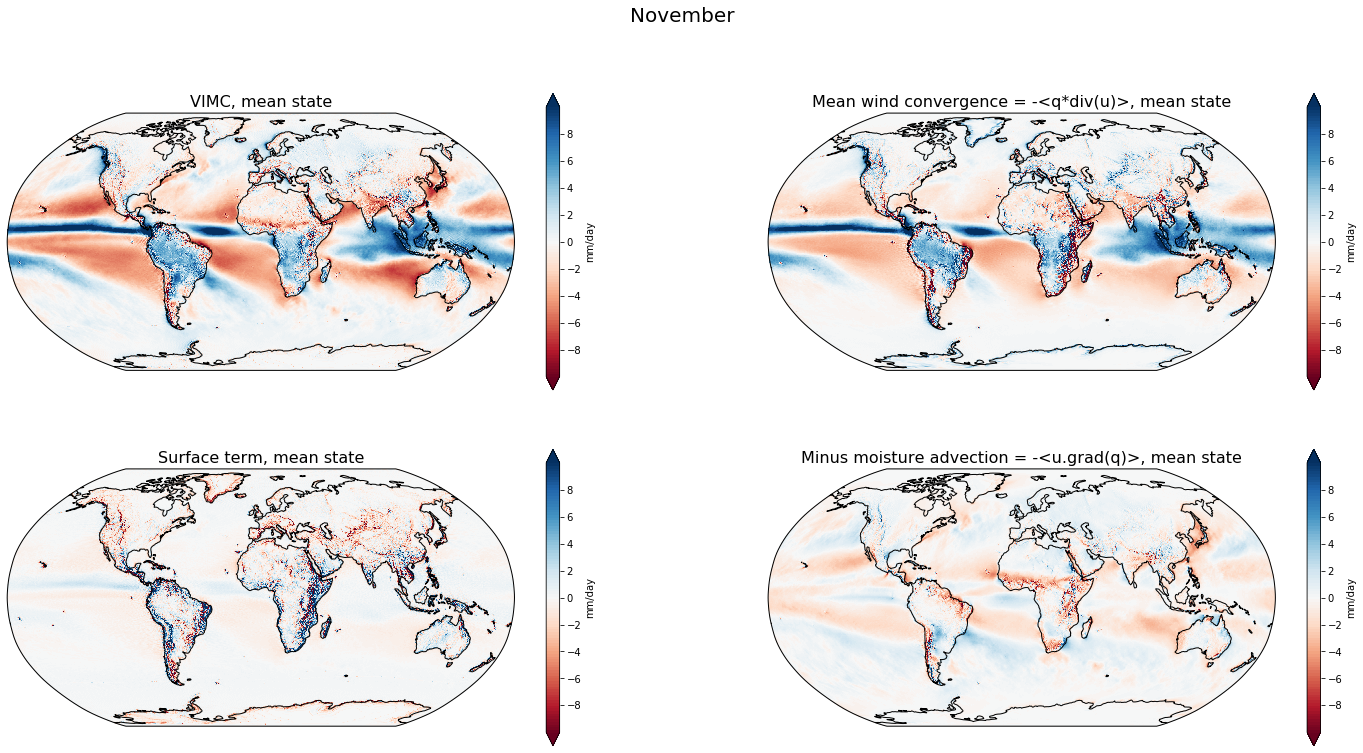

In [79]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(25,12),subplot_kw={'projection': ccrs.Robinson()})
mc_tmean_nov.plot( ax=ax1,transform=ccrs.PlateCarree(),cmap=plt.cm.RdBu,cbar_kwargs={"label":"mm/day","ticks":np.arange(-8.,10.,2.)},levels=np.linspace(-10.,10.,100))
conv_term_nov.plot(ax=ax2,transform=ccrs.PlateCarree(),cmap=plt.cm.RdBu,cbar_kwargs={"label":"mm/day","ticks":np.arange(-8.,10.,2.)},levels=np.linspace(-10.,10.,100))
sfc_term_nov.plot( ax=ax3,transform=ccrs.PlateCarree(),cmap=plt.cm.RdBu,cbar_kwargs={"label":"mm/day","ticks":np.arange(-8.,10.,2.)},levels=np.linspace(-10.,10.,100))
adv_term_nov.plot( ax=ax4,transform=ccrs.PlateCarree(),cmap=plt.cm.RdBu,cbar_kwargs={"label":"mm/day","ticks":np.arange(-8.,10.,2.)},levels=np.linspace(-10.,10.,100))
ax1.coastlines();ax2.coastlines();ax3.coastlines();ax4.coastlines()
ax1.set_title("VIMC, mean state",fontsize=16);ax2.set_title("Mean wind convergence = -<q*div(u)>, mean state",fontsize=16)
ax3.set_title("Surface term, mean state",fontsize=16);ax4.set_title("Minus moisture advection = -<u.grad(q)>, mean state",fontsize=16)

fig.suptitle("November",fontsize=20)


Text(0.5, 0.98, 'May')

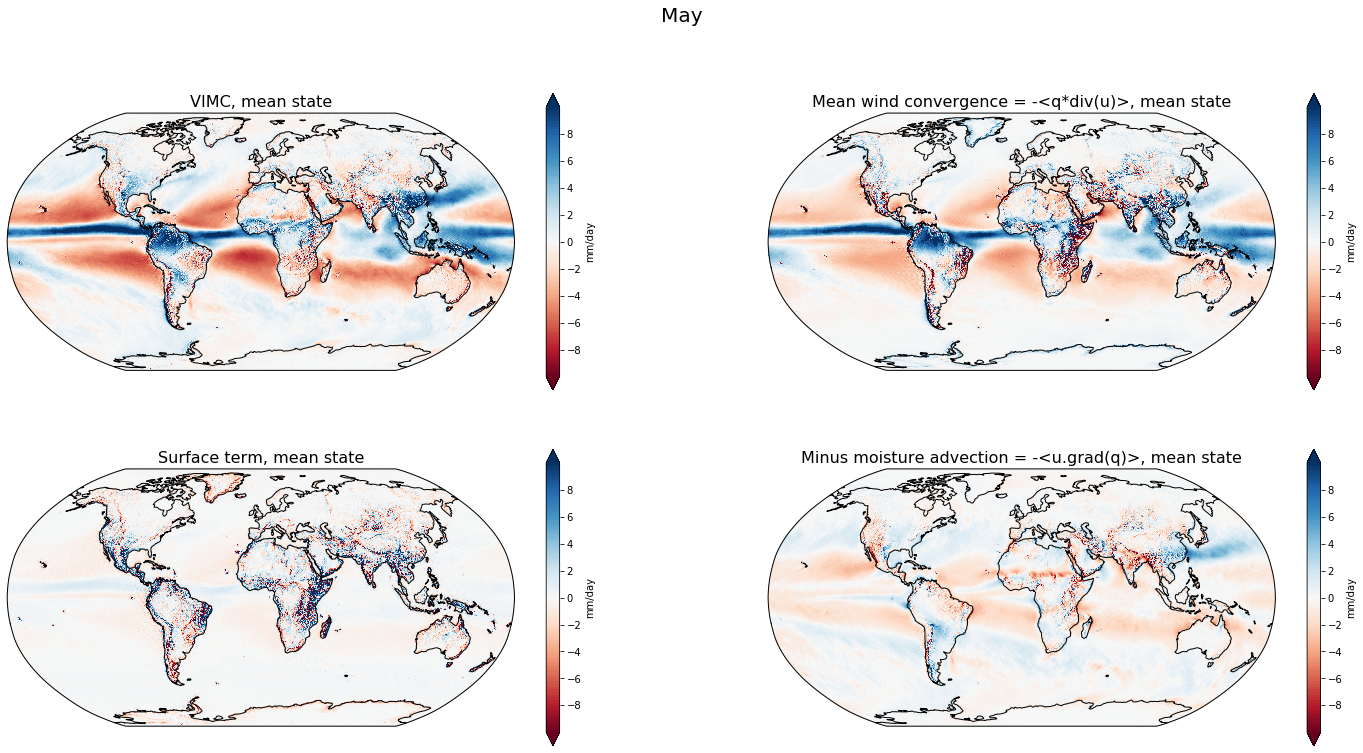

In [80]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(25,12),subplot_kw={'projection': ccrs.Robinson()})
mc_tmean_may.plot( ax=ax1,transform=ccrs.PlateCarree(),cmap=plt.cm.RdBu,cbar_kwargs={"label":"mm/day","ticks":np.arange(-8.,10.,2.)},levels=np.linspace(-10.,10.,100))
conv_term_may.plot(ax=ax2,transform=ccrs.PlateCarree(),cmap=plt.cm.RdBu,cbar_kwargs={"label":"mm/day","ticks":np.arange(-8.,10.,2.)},levels=np.linspace(-10.,10.,100))
sfc_term_may.plot( ax=ax3,transform=ccrs.PlateCarree(),cmap=plt.cm.RdBu,cbar_kwargs={"label":"mm/day","ticks":np.arange(-8.,10.,2.)},levels=np.linspace(-10.,10.,100))
adv_term_may.plot( ax=ax4,transform=ccrs.PlateCarree(),cmap=plt.cm.RdBu,cbar_kwargs={"label":"mm/day","ticks":np.arange(-8.,10.,2.)},levels=np.linspace(-10.,10.,100))
ax1.coastlines();ax2.coastlines();ax3.coastlines();ax4.coastlines()
ax1.set_title("VIMC, mean state",fontsize=16);ax2.set_title("Mean wind convergence = -<q*div(u)>, mean state",fontsize=16)
ax3.set_title("Surface term, mean state",fontsize=16);ax4.set_title("Minus moisture advection = -<u.grad(q)>, mean state",fontsize=16)

fig.suptitle("May",fontsize=20)



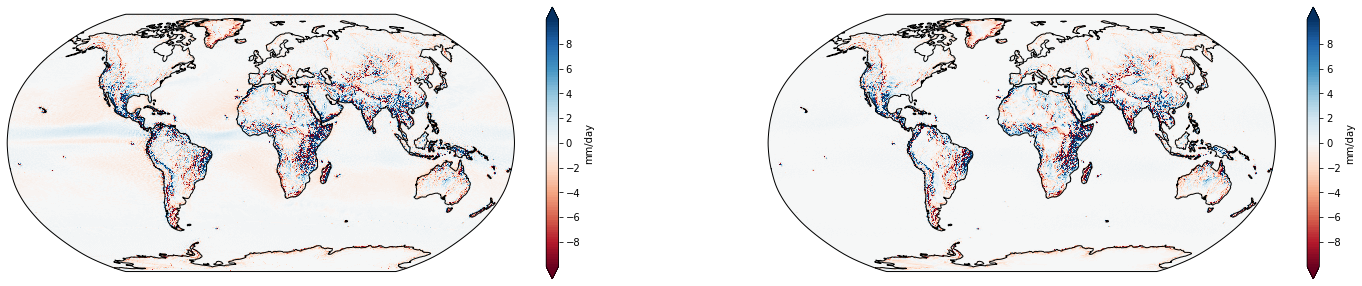

In [67]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(25,5),subplot_kw={'projection': ccrs.Robinson()})
sfc_term_may.plot( ax=ax1,transform=ccrs.PlateCarree(),cmap=plt.cm.RdBu,cbar_kwargs={"label":"mm/day","ticks":np.arange(-8.,10.,2.)},levels=np.linspace(-10.,10.,100))
sfc_term_may2.plot(ax=ax2,transform=ccrs.PlateCarree(),cmap=plt.cm.RdBu,cbar_kwargs={"label":"mm/day","ticks":np.arange(-8.,10.,2.)},levels=np.linspace(-10.,10.,100))

ax1.coastlines();ax2.coastlines()

# Breakdown for each region

## Climatology

In [16]:
from tabulate import tabulate

print(' '*40+'\033[1m'+ "Moisture budget over the whole region (land+ocean)" + '\033[0m')

tab=[]
tab2=[]
for i in range(len(boxNH1)):
    pr   = np.array(region_mean2D(  mean_pr_nov.sel(latitude=slice(50., -50.)), trmm_nh_winter_mask1,boxNH1[i]))
    mc   = np.array(region_mean2D( mc_tmean_nov.sel(latitude=slice(50., -50.)), trmm_nh_winter_mask1,boxNH1[i]))
    conv = np.array(region_mean2D(conv_term_nov.sel(latitude=slice(50., -50.)), trmm_nh_winter_mask1,boxNH1[i]))
    surf = np.array(region_mean2D( sfc_term_nov.sel(latitude=slice(50., -50.)), trmm_nh_winter_mask1,boxNH1[i]))
    adv  = np.array(region_mean2D( adv_term_nov.sel(latitude=slice(50., -50.)), trmm_nh_winter_mask1,boxNH1[i]))
    tab.append([namesNH[i], "%.2f"%pr, "%.2f"%(pr-mc), "%.2f"%conv, "%.2f"%adv, "%.2f"%surf])
    tab2.append([namesNH[i], "%.2f"%mc, "%i%%"%(conv/mc*100), "%i%%"%(adv/mc*100), "%i%%"%(surf/mc*100)])
print(tabulate(tab, headers=['Region'+' '*17, 'Precip (mm/day)', 'Evap ~ P-MC','-<q*div(u)>','-<u.grad(q)>','Surface term']))
#print(tabulate(tab2, headers=['Region'+' '*17, 'Moisture convergence','Mean wind convergence = -<q*div(u)>','Minus moisture advection = -<u.grad(q)>','Surface term']))

tab=[]
tab2=[]
for i in range(len(boxSH1)):
    pr   = np.array(region_mean2D(  mean_pr_may.sel(latitude=slice(50., -50.)), trmm_sh_winter_mask1,boxSH1[i]))
    mc   = np.array(region_mean2D( mc_tmean_may.sel(latitude=slice(50., -50.)), trmm_sh_winter_mask1,boxSH1[i]))
    conv = np.array(region_mean2D(conv_term_may.sel(latitude=slice(50., -50.)), trmm_sh_winter_mask1,boxSH1[i]))
    surf = np.array(region_mean2D( sfc_term_may.sel(latitude=slice(50., -50.)), trmm_sh_winter_mask1,boxSH1[i]))
    adv  = np.array(region_mean2D( adv_term_may.sel(latitude=slice(50., -50.)), trmm_sh_winter_mask1,boxSH1[i]))
    tab.append([namesSH[i], "%.2f"%pr, "%.2f"%(pr-mc), "%.2f"%conv, "%.2f"%adv, "%.2f"%surf])
    tab2.append([namesSH[i], "%.2f"%mc, "%i%%"%(conv/mc*100), "%i%%"%(adv/mc*100), "%i%%"%(surf/mc*100)])
print("\n"+tabulate(tab, headers=['Region'+' '*17, 'Precip (mm/day)', 'Evap ~ P-MC','-<q*div(u)>','-<u.grad(q)>','Surface term']))

    

                                        Moisture budget over the whole region (land+ocean)
Region                       Precip (mm/day)    Evap ~ P-MC    -<q*div(u)>    -<u.grad(q)>    Surface term
-------------------------  -----------------  -------------  -------------  --------------  --------------
Central America                         5.37           3.94           1.78           -1.37            1.03
Venezuela                               5.11           4.41           0.76           -0.75            0.69
South India / Sri Lanka                 8.64           3.17           4.94           -0.24            0.78
Vietnam / South China Sea               8.59           3.58           3.13           -1.05            2.94
Philippines                             8.74           3.11           4.27           -1.77            3.13
Malaysia                               10.7            3.25           7.12           -0.21            0.55

Region                       Precip (mm/day)    Evap

In [17]:
from tabulate import tabulate
landmask = xr.open_dataset("/global/cfs/projectdirs/m3522/cmip6/ERA5/e5.oper.invariant/197901/e5.oper.invariant.128_172_lsm.ll025sc.1979010100_1979010100.nc").LSM.isel(time=0)
landmask50=landmask.sel(latitude=slice(50., -50.)).interp_like(trmm_nh_winter_mask1)

print(' '*40+'\033[1m'+ "Moisture budget over land only" + '\033[0m')

tab=[]
tab2=[]
for i in range(len(boxNH1)):
    pr   = np.array(region_mean2D(  mean_pr_nov.sel(latitude=slice(50., -50.)), landmask50*trmm_nh_winter_mask1,boxNH1[i]))
    mc   = np.array(region_mean2D( mc_tmean_nov.sel(latitude=slice(50., -50.)), landmask50*trmm_nh_winter_mask1,boxNH1[i]))
    conv = np.array(region_mean2D(conv_term_nov.sel(latitude=slice(50., -50.)), landmask50*trmm_nh_winter_mask1,boxNH1[i]))
    surf = np.array(region_mean2D( sfc_term_nov.sel(latitude=slice(50., -50.)), landmask50*trmm_nh_winter_mask1,boxNH1[i]))
    adv  = np.array(region_mean2D( adv_term_nov.sel(latitude=slice(50., -50.)), landmask50*trmm_nh_winter_mask1,boxNH1[i]))
    tab.append([namesNH[i], "%.2f"%pr, "%.2f"%(pr-mc), "%.2f"%conv, "%.2f"%adv, "%.2f"%surf])
    tab2.append([namesNH[i], "%.2f"%mc, "%i%%"%(conv/mc*100), "%i%%"%(adv/mc*100), "%i%%"%(surf/mc*100)])
print(tabulate(tab, headers=['Region'+' '*17, 'Precip (mm/day)', 'Evap ~ P-MC','-<q*div(u)>','-<u.grad(q)>','Surface term']))
#print(tabulate(tab2, headers=['Region'+' '*17, 'Moisture convergence','Mean wind convergence = -<q*div(u)>','Minus moisture advection = -<u.grad(q)>','Surface term']))

tab=[]
tab2=[]
for i in range(len(boxSH1)):
    pr   = np.array(region_mean2D(  mean_pr_may.sel(latitude=slice(50., -50.)), landmask50*trmm_sh_winter_mask1,boxSH1[i]))
    mc   = np.array(region_mean2D( mc_tmean_may.sel(latitude=slice(50., -50.)), landmask50*trmm_sh_winter_mask1,boxSH1[i]))
    conv = np.array(region_mean2D(conv_term_may.sel(latitude=slice(50., -50.)), landmask50*trmm_sh_winter_mask1,boxSH1[i]))
    surf = np.array(region_mean2D( sfc_term_may.sel(latitude=slice(50., -50.)), landmask50*trmm_sh_winter_mask1,boxSH1[i]))
    adv  = np.array(region_mean2D( adv_term_may.sel(latitude=slice(50., -50.)), landmask50*trmm_sh_winter_mask1,boxSH1[i]))
    tab.append([namesSH[i], "%.2f"%pr, "%.2f"%(pr-mc), "%.2f"%conv, "%.2f"%adv, "%.2f"%surf])
    tab2.append([namesSH[i], "%.2f"%mc, "%i%%"%(conv/mc*100), "%i%%"%(adv/mc*100), "%i%%"%(surf/mc*100)])
print("\n"+tabulate(tab, headers=['Region'+' '*17, 'Precip (mm/day)', 'Evap ~ P-MC','-<q*div(u)>','-<u.grad(q)>','Surface term']))


                                        Moisture budget over land only
Region                       Precip (mm/day)    Evap ~ P-MC    -<q*div(u)>    -<u.grad(q)>    Surface term
-------------------------  -----------------  -------------  -------------  --------------  --------------
Central America                         5.76           2.44          -0.34           -1.9             5.55
Venezuela                               4.8            1.67          -1.09           -0.27            4.5
South India / Sri Lanka                 6.66           3.62           1.38           -1.02            2.69
Vietnam / South China Sea               8.94           5.75         -12.84            1.16           14.86
Philippines                             8.18           4.5           -2.91           -0.49            7.09
Malaysia                               10.57           3.36           6.79            0.02            0.41

Region                       Precip (mm/day)    Evap ~ P-MC    -<q*div(u)

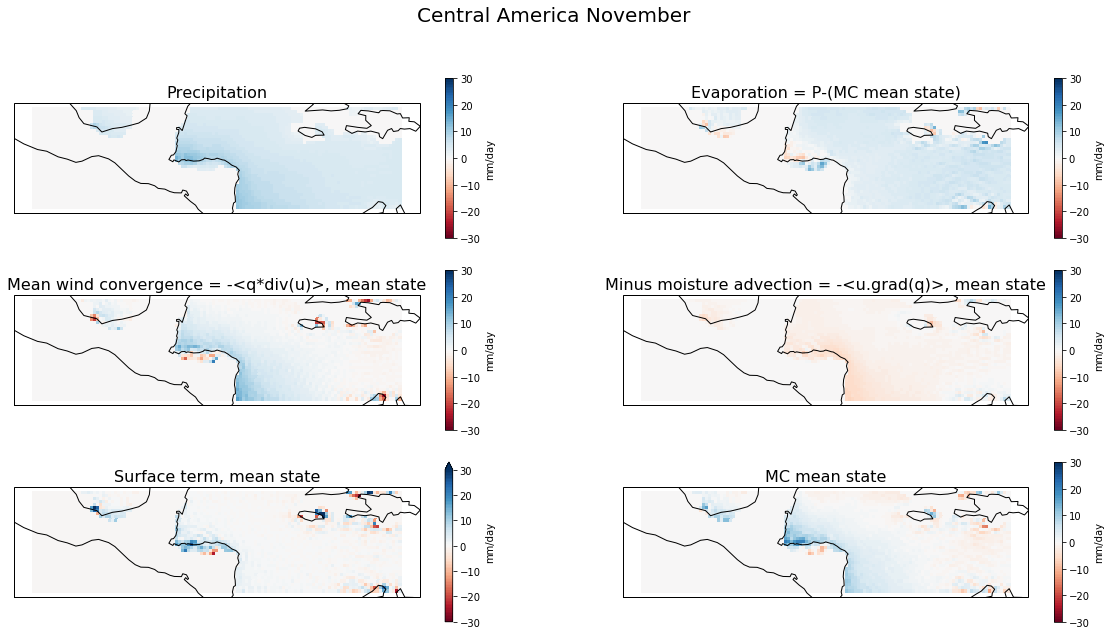

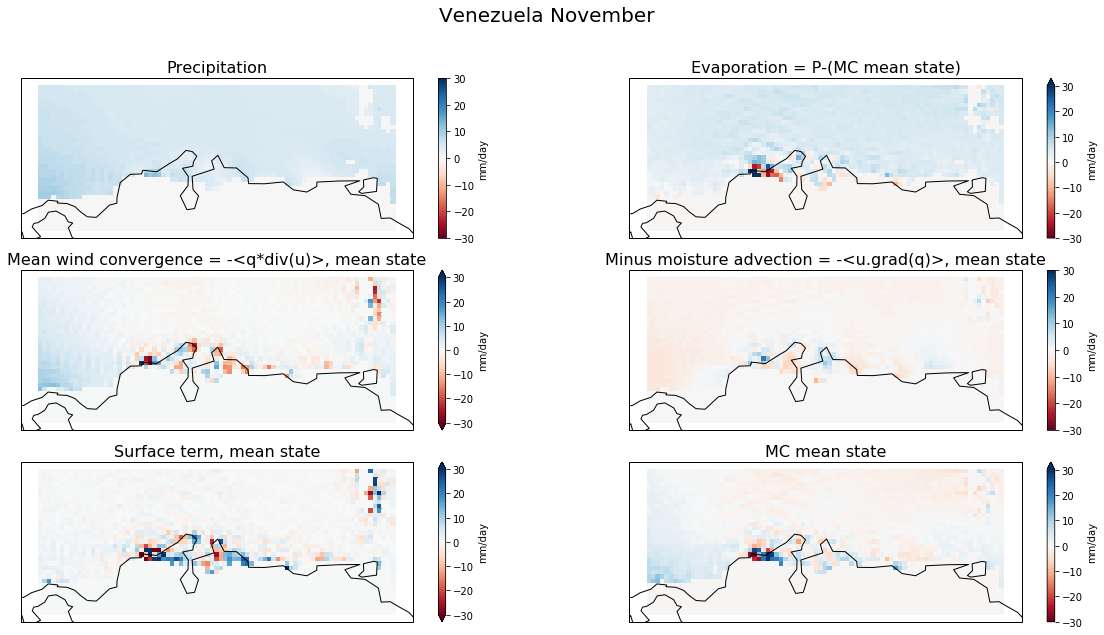

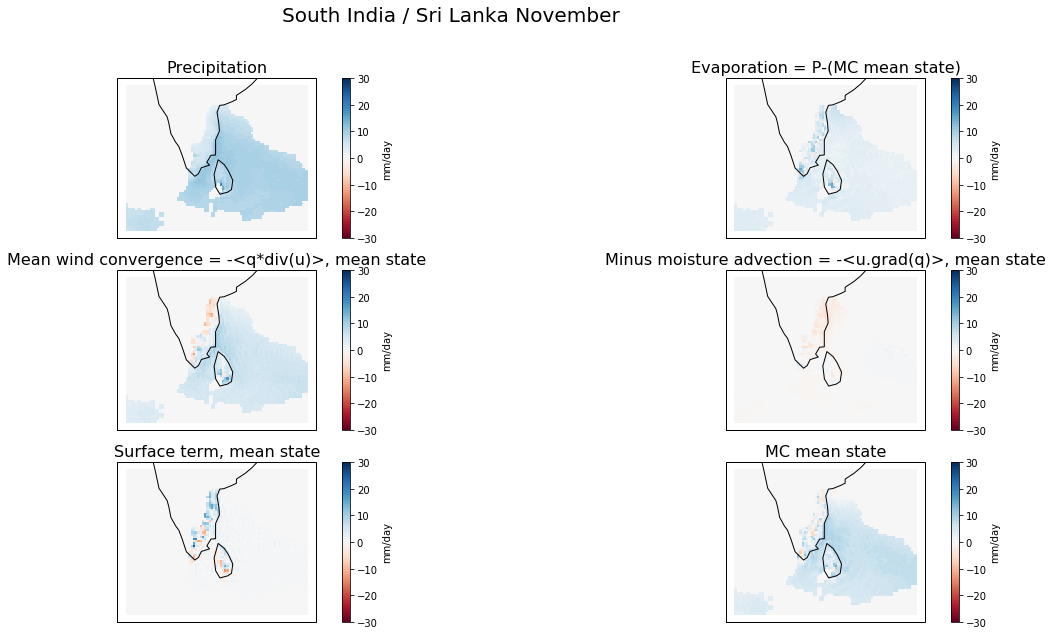

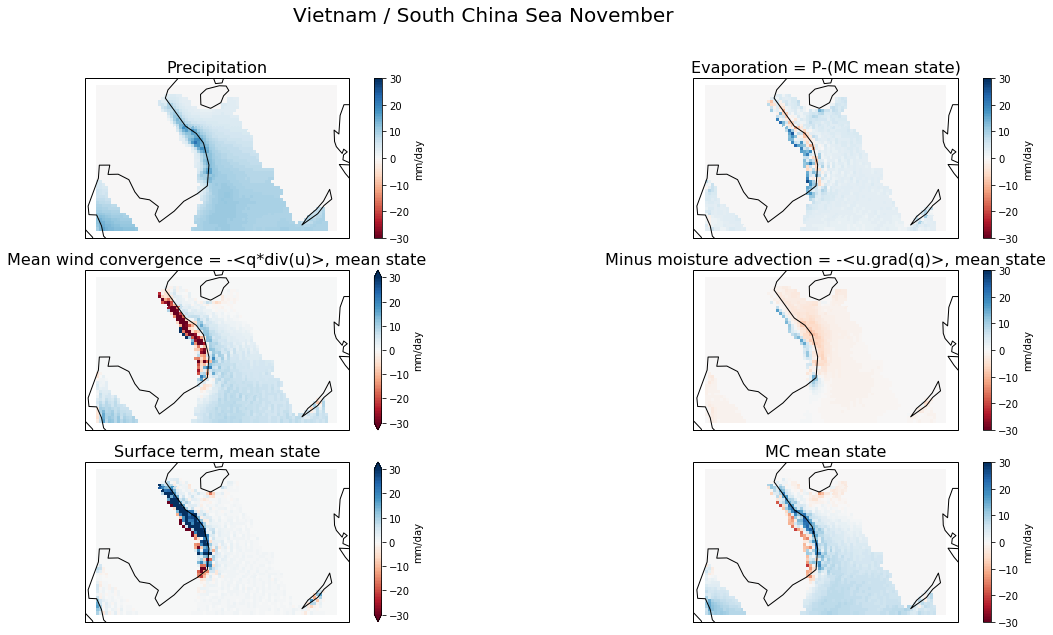

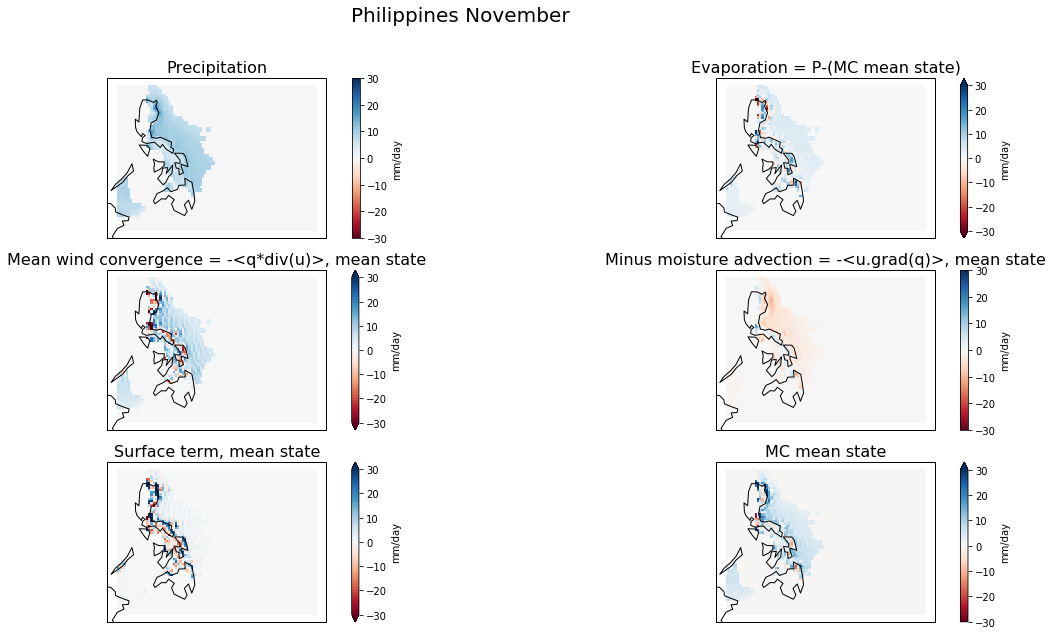

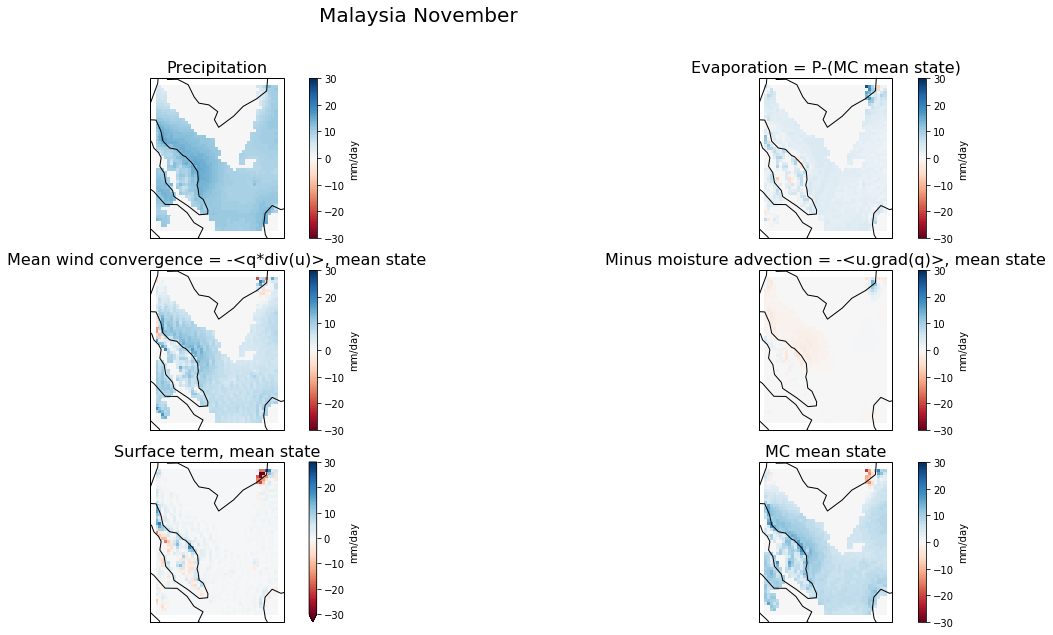

In [95]:
for i,box in enumerate(boxNH1):
    mask = trmm_nh_winter_mask1.sel(longitude=slice(box[0],box[1]),latitude=slice(box[3],box[2]))
    
    prrr = mask*  mean_pr_nov.sel(longitude=slice(box[0],box[1]),latitude=slice(box[3],box[2]))
    mccc = mask* mc_tmean_nov.sel(longitude=slice(box[0],box[1]),latitude=slice(box[3],box[2]))
    conv = mask*conv_term_nov.sel(longitude=slice(box[0],box[1]),latitude=slice(box[3],box[2]))
    surf = mask* sfc_term_nov.sel(longitude=slice(box[0],box[1]),latitude=slice(box[3],box[2]))
    advv = mask* adv_term_nov.sel(longitude=slice(box[0],box[1]),latitude=slice(box[3],box[2]))
    evap = prrr-mccc
    
    fig, ((ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3,2,figsize=(20,10),subplot_kw={'projection': ccrs.PlateCarree()})
    prrr.plot(ax=ax1,transform=ccrs.PlateCarree(),cmap=plt.cm.RdBu,cbar_kwargs={"label":"mm/day","ticks":np.arange(-30.,31.,10.)},levels=np.linspace(-30.,30.,100))
    evap.plot(ax=ax2,transform=ccrs.PlateCarree(),cmap=plt.cm.RdBu,cbar_kwargs={"label":"mm/day","ticks":np.arange(-30.,31.,10.)},levels=np.linspace(-30.,30.,100))
    conv.plot(ax=ax3,transform=ccrs.PlateCarree(),cmap=plt.cm.RdBu,cbar_kwargs={"label":"mm/day","ticks":np.arange(-30.,31.,10.)},levels=np.linspace(-30.,30.,100))
    advv.plot(ax=ax4,transform=ccrs.PlateCarree(),cmap=plt.cm.RdBu,cbar_kwargs={"label":"mm/day","ticks":np.arange(-30.,31.,10.)},levels=np.linspace(-30.,30.,100))
    surf.plot(ax=ax5,transform=ccrs.PlateCarree(),cmap=plt.cm.RdBu,cbar_kwargs={"label":"mm/day","ticks":np.arange(-30.,31.,10.)},levels=np.linspace(-30.,30.,100))
    mccc.plot(ax=ax6,transform=ccrs.PlateCarree(),cmap=plt.cm.RdBu,cbar_kwargs={"label":"mm/day","ticks":np.arange(-30.,31.,10.)},levels=np.linspace(-30.,30.,100))
        
    ax1.coastlines();ax2.coastlines();ax3.coastlines();ax4.coastlines();ax5.coastlines();ax6.coastlines()
    ax1.set_title("Precipitation",fontsize=16);ax2.set_title("Evaporation = P-(MC mean state)",fontsize=16)
    ax3.set_title("Mean wind convergence = -<q*div(u)>, mean state",fontsize=16);ax4.set_title("Minus moisture advection = -<u.grad(q)>, mean state",fontsize=16)
    ax5.set_title("Surface term, mean state",fontsize=16);ax6.set_title("MC mean state",fontsize=16)
    
    fig.suptitle(namesNH[i]+" November",fontsize=20)
    
    

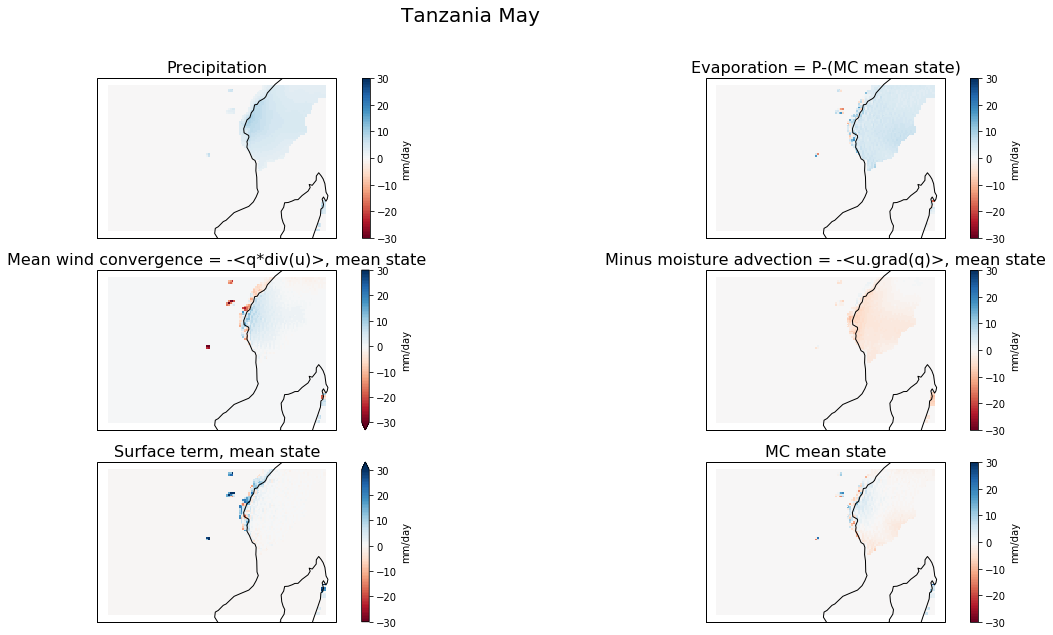

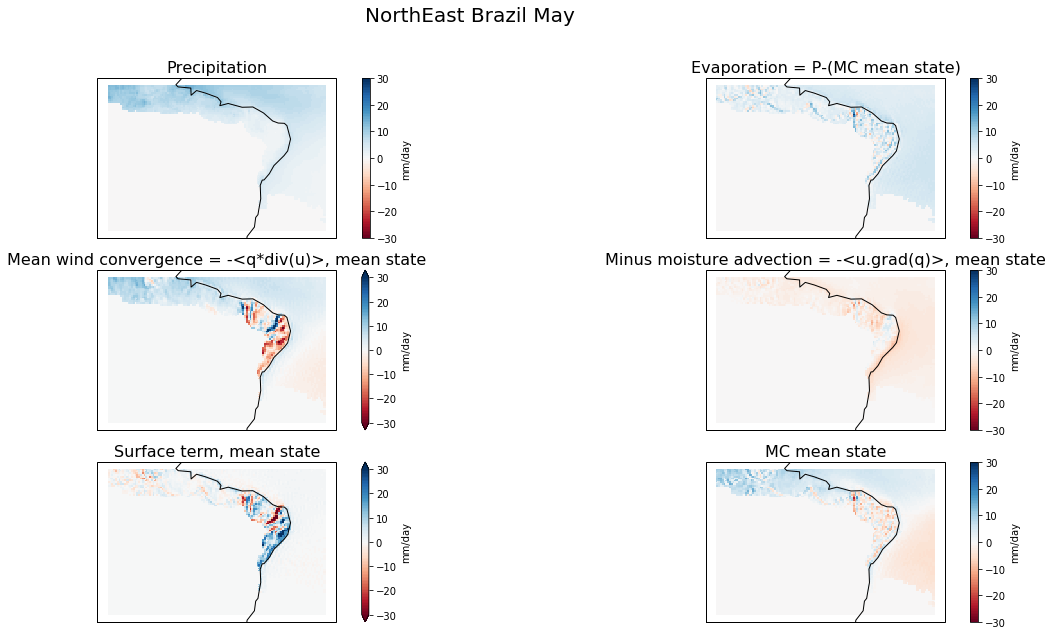

In [96]:
for i,box in enumerate(boxSH1):
    mask = trmm_sh_winter_mask1.sel(longitude=slice(box[0],box[1]),latitude=slice(box[3],box[2]))
    
    prrr = mask*  mean_pr_may.sel(longitude=slice(box[0],box[1]),latitude=slice(box[3],box[2]))
    mccc = mask* mc_tmean_may.sel(longitude=slice(box[0],box[1]),latitude=slice(box[3],box[2]))
    conv = mask*conv_term_may.sel(longitude=slice(box[0],box[1]),latitude=slice(box[3],box[2]))
    surf = mask* sfc_term_may.sel(longitude=slice(box[0],box[1]),latitude=slice(box[3],box[2]))
    advv = mask* adv_term_may.sel(longitude=slice(box[0],box[1]),latitude=slice(box[3],box[2]))
    evap = prrr-mccc
    
    fig, ((ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3,2,figsize=(20,10),subplot_kw={'projection': ccrs.PlateCarree()})
    prrr.plot(ax=ax1,transform=ccrs.PlateCarree(),cmap=plt.cm.RdBu,cbar_kwargs={"label":"mm/day","ticks":np.arange(-30.,31.,10.)},levels=np.linspace(-30.,30.,100))
    evap.plot(ax=ax2,transform=ccrs.PlateCarree(),cmap=plt.cm.RdBu,cbar_kwargs={"label":"mm/day","ticks":np.arange(-30.,31.,10.)},levels=np.linspace(-30.,30.,100))
    conv.plot(ax=ax3,transform=ccrs.PlateCarree(),cmap=plt.cm.RdBu,cbar_kwargs={"label":"mm/day","ticks":np.arange(-30.,31.,10.)},levels=np.linspace(-30.,30.,100))
    advv.plot(ax=ax4,transform=ccrs.PlateCarree(),cmap=plt.cm.RdBu,cbar_kwargs={"label":"mm/day","ticks":np.arange(-30.,31.,10.)},levels=np.linspace(-30.,30.,100))
    surf.plot(ax=ax5,transform=ccrs.PlateCarree(),cmap=plt.cm.RdBu,cbar_kwargs={"label":"mm/day","ticks":np.arange(-30.,31.,10.)},levels=np.linspace(-30.,30.,100))
    mccc.plot(ax=ax6,transform=ccrs.PlateCarree(),cmap=plt.cm.RdBu,cbar_kwargs={"label":"mm/day","ticks":np.arange(-30.,31.,10.)},levels=np.linspace(-30.,30.,100))
        
    ax1.coastlines();ax2.coastlines();ax3.coastlines();ax4.coastlines();ax5.coastlines();ax6.coastlines()
    ax1.set_title("Precipitation",fontsize=16);ax2.set_title("Evaporation = P-(MC mean state)",fontsize=16)
    ax3.set_title("Mean wind convergence = -<q*div(u)>, mean state",fontsize=16);ax4.set_title("Minus moisture advection = -<u.grad(q)>, mean state",fontsize=16)
    ax5.set_title("Surface term, mean state",fontsize=16);ax6.set_title("MC mean state",fontsize=16)
    
    fig.suptitle(namesSH[i]+" May",fontsize=20)

## Dry vs wet years

In [58]:
ghcn = xr.open_dataset("/global/cscratch1/sd/qnicolas/ghcn.precip.mon.total.nc",decode_times=False)
ghcn.coords['time'] = pd.to_datetime('1800-01-01') + pd.to_timedelta(np.array(ghcn.coords['time']),'d')
ghcn=ghcn.rename({'lat':'latitude','lon':'longitude'}).precip

In [ ]:
#Change year, define based on ghcn terciles

In [47]:
#compute precip
def timesel(year,month,targetmonth):
    return (year >= 1979) & (year < 2019) & (month == targetmonth)

all_pr_nov = all_pr.sel(time = timesel(all_pr['time.year'],all_pr['time.month'],11))
all_mc_nov = all_mc.sel(time = timesel(all_mc['time.year'],all_mc['time.month'],11))
all_pr_may = all_pr.sel(time = timesel(all_pr['time.year'],all_pr['time.month'],5))
all_mc_may = all_mc.sel(time = timesel(all_mc['time.year'],all_mc['time.month'],5))

In [44]:
all_qq_nov = retrieve_era5_month("11",'128_133_q' );all_qq_may = retrieve_era5_month("05",'128_133_q' )
all_uu_nov = retrieve_era5_month("11",'128_131_u' );all_uu_may = retrieve_era5_month("05",'128_131_u' )
all_vv_nov = retrieve_era5_month("11",'128_132_v' );all_vv_may = retrieve_era5_month("05",'128_132_v' )
all_ww_nov = retrieve_era5_month("11",'128_135_w' );all_ww_may = retrieve_era5_month("05",'128_135_w' )
all_ps_nov = retrieve_era5_month("11",'128_134_sp');all_ps_may = retrieve_era5_month("05",'128_134_sp')

In [71]:
# determine dry and wet years for each region,with ghcn
ghcn_nov = ghcn.sel(time = timesel(ghcn['time.year'],ghcn['time.month'],11))
ghcn_may = ghcn.sel(time = timesel(ghcn['time.year'],ghcn['time.month'],5))

nwettest = int((2015-1979)/3);ndriest = nwettest
drywetyearsNH = []
for i,box in enumerate(boxNH1):
    ghcn_nov_box = np.array([region_mean2D(ghcn_nov.sel(latitude=slice(50., -50.),time=y),
                                           trmm_nh_winter_mask1.interp_like(ghcn_nov),box) for y in ghcn_nov.time])
    drywetyearsNH.append({"dry" : ghcn_nov.time[np.argpartition(ghcn_nov_box, ndriest)[:ndriest]], "wet" : ghcn_nov.time[np.argpartition(-ghcn_nov_box, nwettest)[:nwettest]]})

drywetyearsSH = []
for i,box in enumerate(boxSH1):
    ghcn_may_box = np.array([region_mean2D(ghcn_may.sel(latitude=slice(50., -50.),time=y),
                                           trmm_sh_winter_mask1.interp_like(ghcn_may),box) for y in ghcn_may.time])
    drywetyearsSH.append({"dry" : ghcn_may.time[np.argpartition(ghcn_may_box, ndriest)[:ndriest]], "wet" : ghcn_may.time[np.argpartition(-ghcn_may_box, nwettest)[:nwettest]]})
    



In [61]:
prNH = []; qqNH = []; uuNH = []; vvNH = []; wwNH = []; psNH = []
t=time.time()
for i,box in enumerate(boxNH1):
    prNH.append({"dry" : all_pr_nov.sel(time=drywetyearsNH[i]["dry"]).mean("time"), "wet" : all_pr_nov.sel(time=drywetyearsNH[i]["wet"]).mean("time")})
    qqNH.append({"dry" : all_qq_nov.sel(time=drywetyearsNH[i]["dry"]).mean("time"), "wet" : all_qq_nov.sel(time=drywetyearsNH[i]["wet"]).mean("time")}) 
    uuNH.append({"dry" : all_uu_nov.sel(time=drywetyearsNH[i]["dry"]).mean("time"), "wet" : all_uu_nov.sel(time=drywetyearsNH[i]["wet"]).mean("time")}) 
    vvNH.append({"dry" : all_vv_nov.sel(time=drywetyearsNH[i]["dry"]).mean("time"), "wet" : all_vv_nov.sel(time=drywetyearsNH[i]["wet"]).mean("time")}) 
    wwNH.append({"dry" : all_ww_nov.sel(time=drywetyearsNH[i]["dry"]).mean("time"), "wet" : all_ww_nov.sel(time=drywetyearsNH[i]["wet"]).mean("time")}) 
    psNH.append({"dry" : all_ps_nov.sel(time=drywetyearsNH[i]["dry"]).mean("time"), "wet" : all_ps_nov.sel(time=drywetyearsNH[i]["wet"]).mean("time")})
    
print(time.time()-t)

In [72]:
prSH = []; qqSH = []; uuSH = []; vvSH = []; wwSH = []; psSH = []
t=time.time()
for i,box in enumerate(boxSH1):
    prSH.append({"dry" : all_pr_may.sel(time=drywetyearsSH[i]["dry"]).mean("time"), "wet" : all_pr_may.sel(time=drywetyearsSH[i]["wet"]).mean("time")})
    qqSH.append({"dry" : all_qq_may.sel(time=drywetyearsSH[i]["dry"]).mean("time"), "wet" : all_qq_may.sel(time=drywetyearsSH[i]["wet"]).mean("time")}) 
    uuSH.append({"dry" : all_uu_may.sel(time=drywetyearsSH[i]["dry"]).mean("time"), "wet" : all_uu_may.sel(time=drywetyearsSH[i]["wet"]).mean("time")}) 
    vvSH.append({"dry" : all_vv_may.sel(time=drywetyearsSH[i]["dry"]).mean("time"), "wet" : all_vv_may.sel(time=drywetyearsSH[i]["wet"]).mean("time")}) 
    wwSH.append({"dry" : all_ww_may.sel(time=drywetyearsSH[i]["dry"]).mean("time"), "wet" : all_ww_may.sel(time=drywetyearsSH[i]["wet"]).mean("time")}) 
    psSH.append({"dry" : all_ps_may.sel(time=drywetyearsSH[i]["dry"]).mean("time"), "wet" : all_ps_may.sel(time=drywetyearsSH[i]["wet"]).mean("time")})
    
print(time.time()-t)

126.30123400688171


In [73]:
mcccNH  =[]; convNH=[]; advvNH =[]; sfccNH =[]    
for i,box in enumerate(boxNH1):
    mcd,cod,add,sfd = compute_mc_terms(qqNH[i]["dry"],uuNH[i]["dry"],vvNH[i]["dry"],wwNH[i]["dry"],psNH[i]["dry"])
    mcw,cow,adw,sfw = compute_mc_terms(qqNH[i]["wet"],uuNH[i]["wet"],vvNH[i]["wet"],wwNH[i]["wet"],psNH[i]["wet"])
    mcccNH.append({"dry" : mcd, "wet" : mcw})
    convNH.append({"dry" : cod, "wet" : cow}) 
    advvNH.append({"dry" : add, "wet" : adw}) 
    sfccNH.append({"dry" : sfd, "wet" : sfw}) 

mcccSH  =[]; convSH=[]; advvSH =[]; sfccSH =[]    
for i,box in enumerate(boxSH1):
    mcd,cod,add,sfd = compute_mc_terms(qqSH[i]["dry"],uuSH[i]["dry"],vvSH[i]["dry"],wwSH[i]["dry"],psSH[i]["dry"])
    mcw,cow,adw,sfw = compute_mc_terms(qqSH[i]["wet"],uuSH[i]["wet"],vvSH[i]["wet"],wwSH[i]["wet"],psSH[i]["wet"])
    mcccSH.append({"dry" : mcd, "wet" : mcw})
    convSH.append({"dry" : cod, "wet" : cow}) 
    advvSH.append({"dry" : add, "wet" : adw}) 
    sfccSH.append({"dry" : sfd, "wet" : sfw}) 


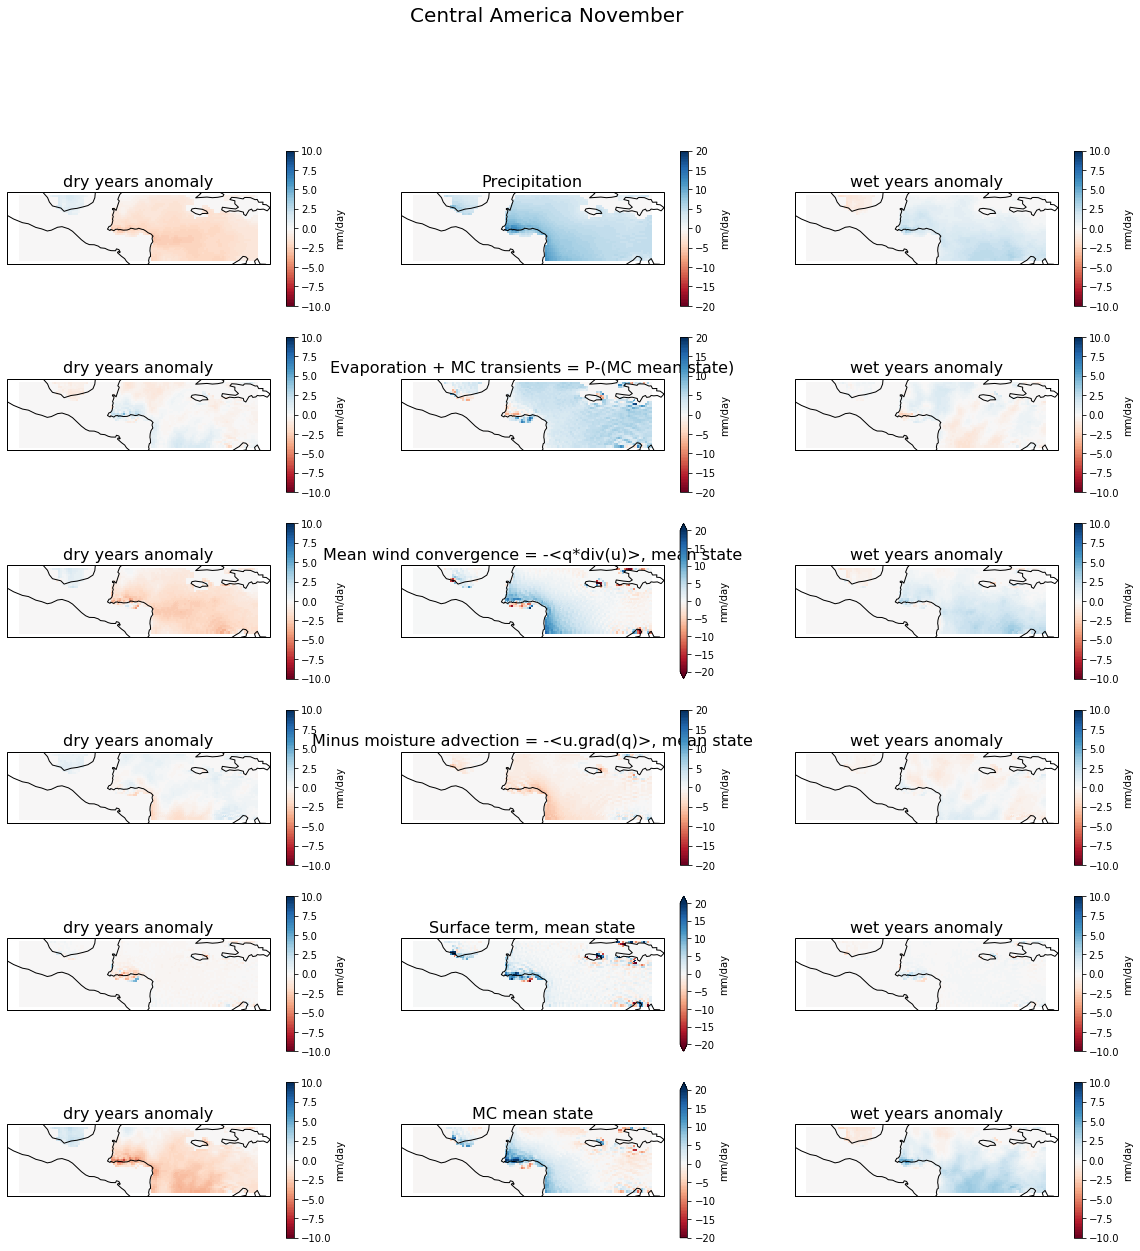

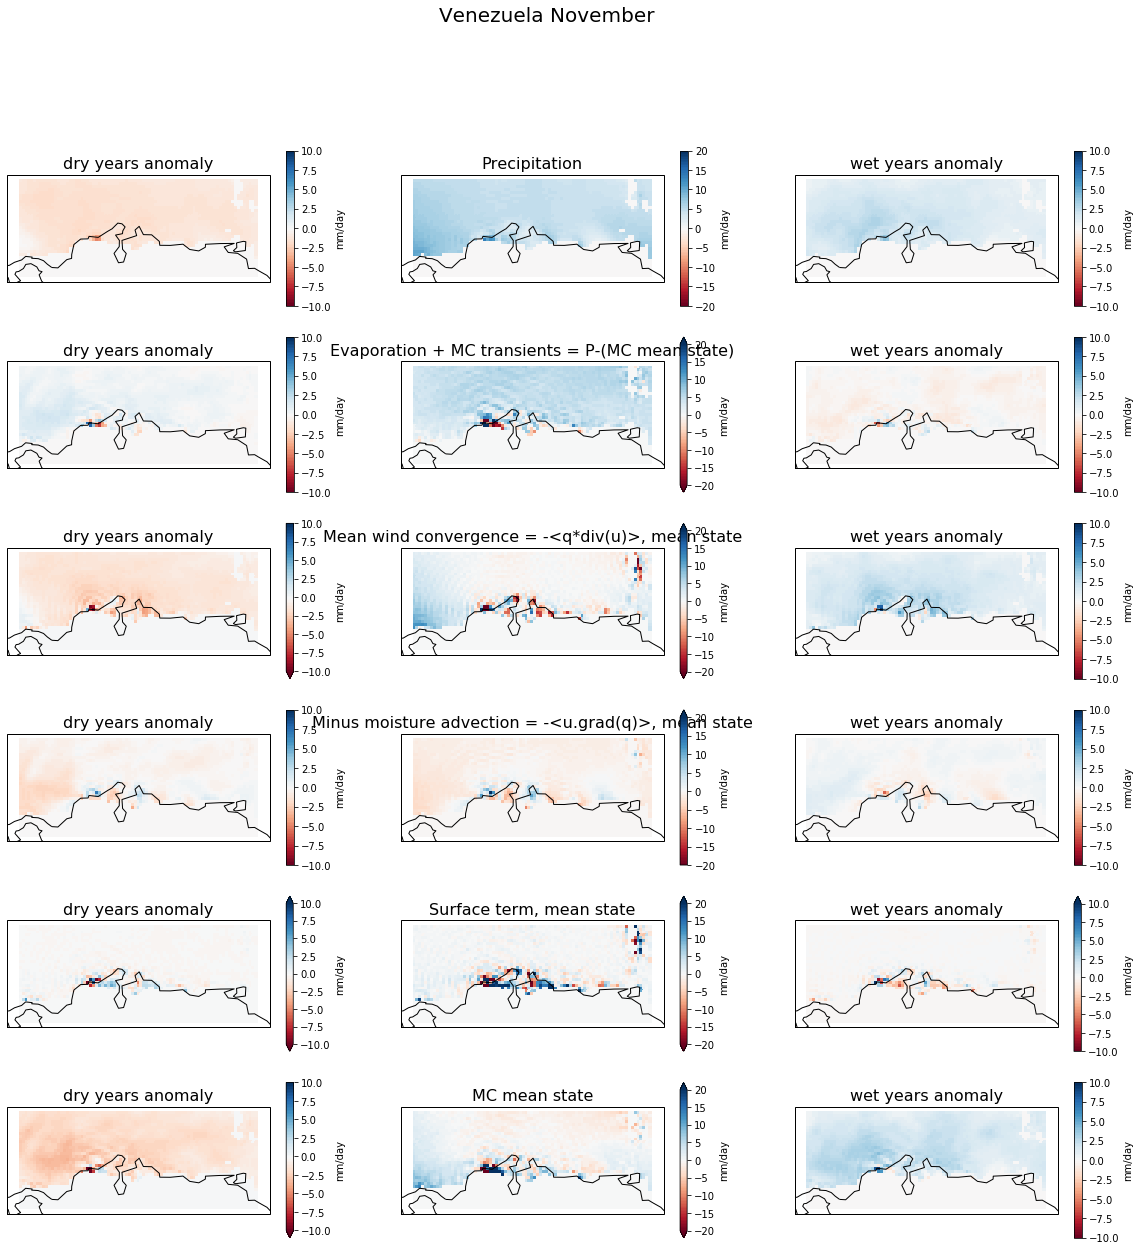

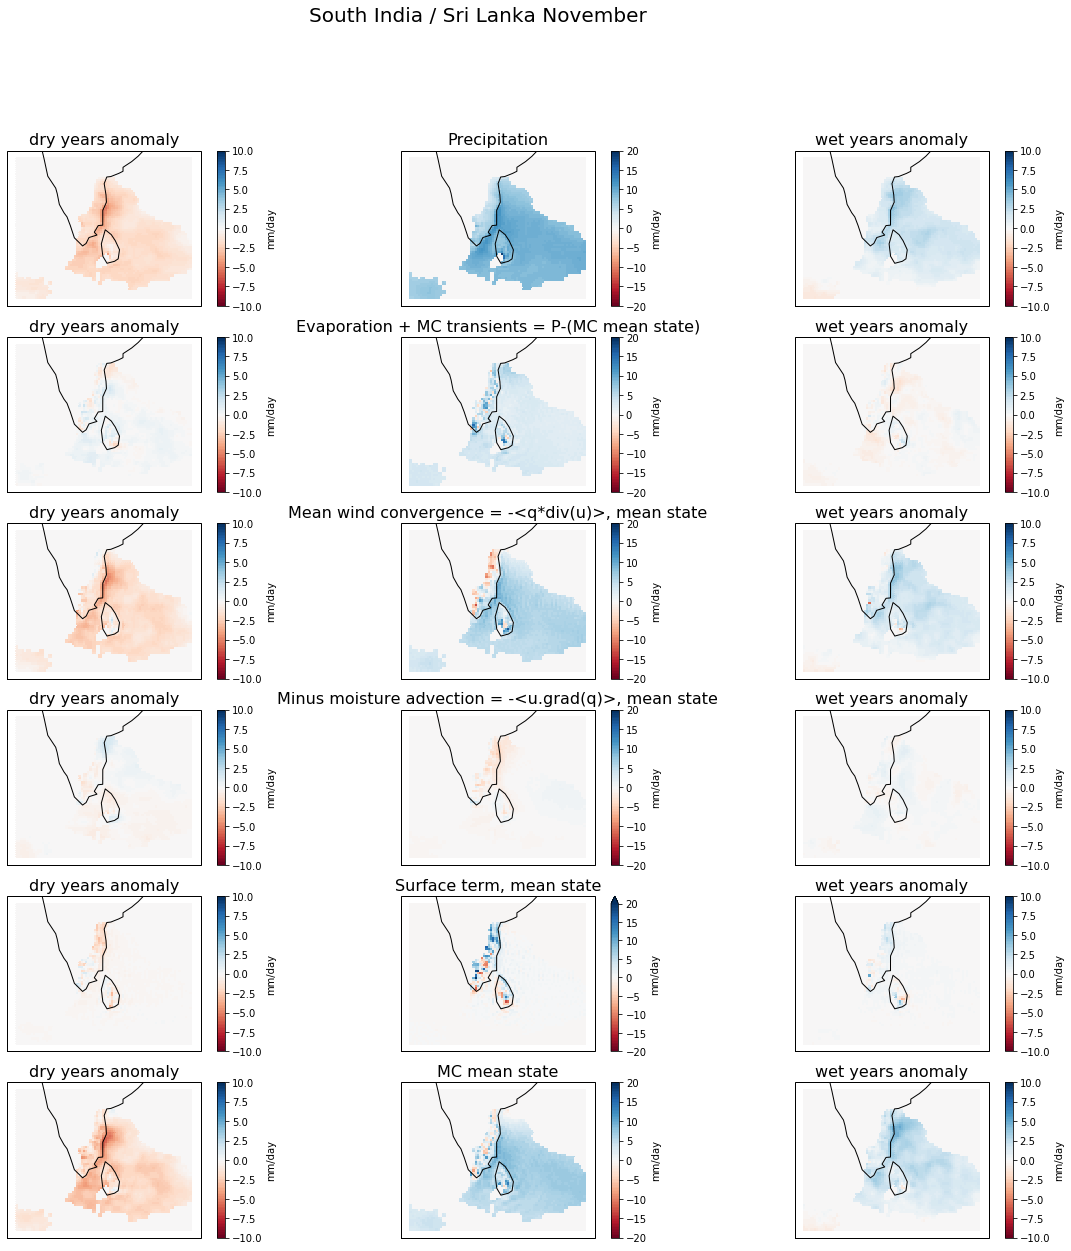

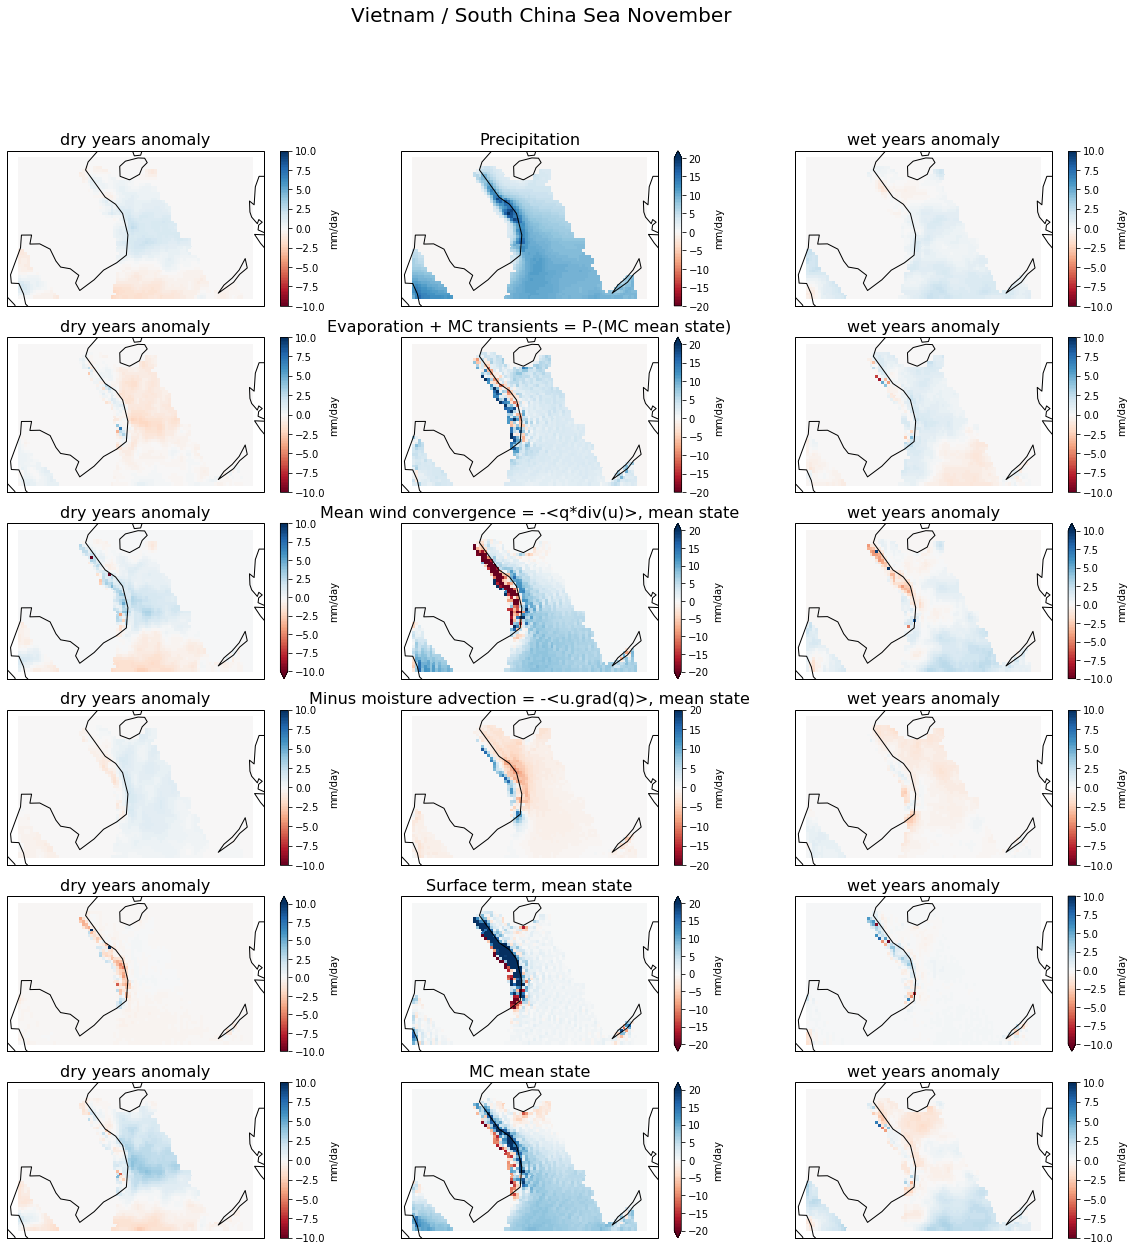

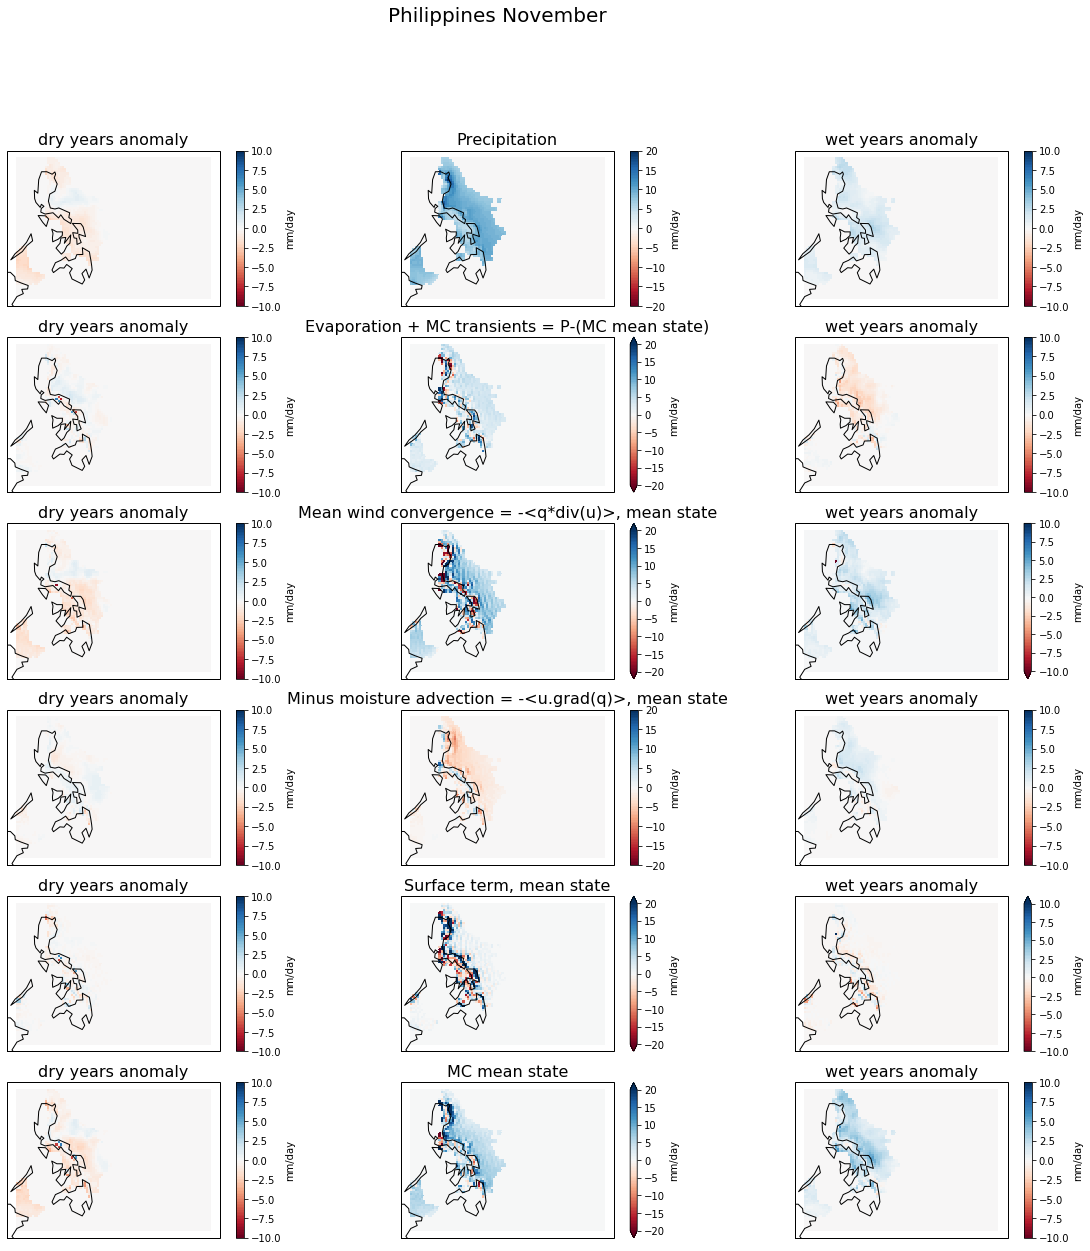

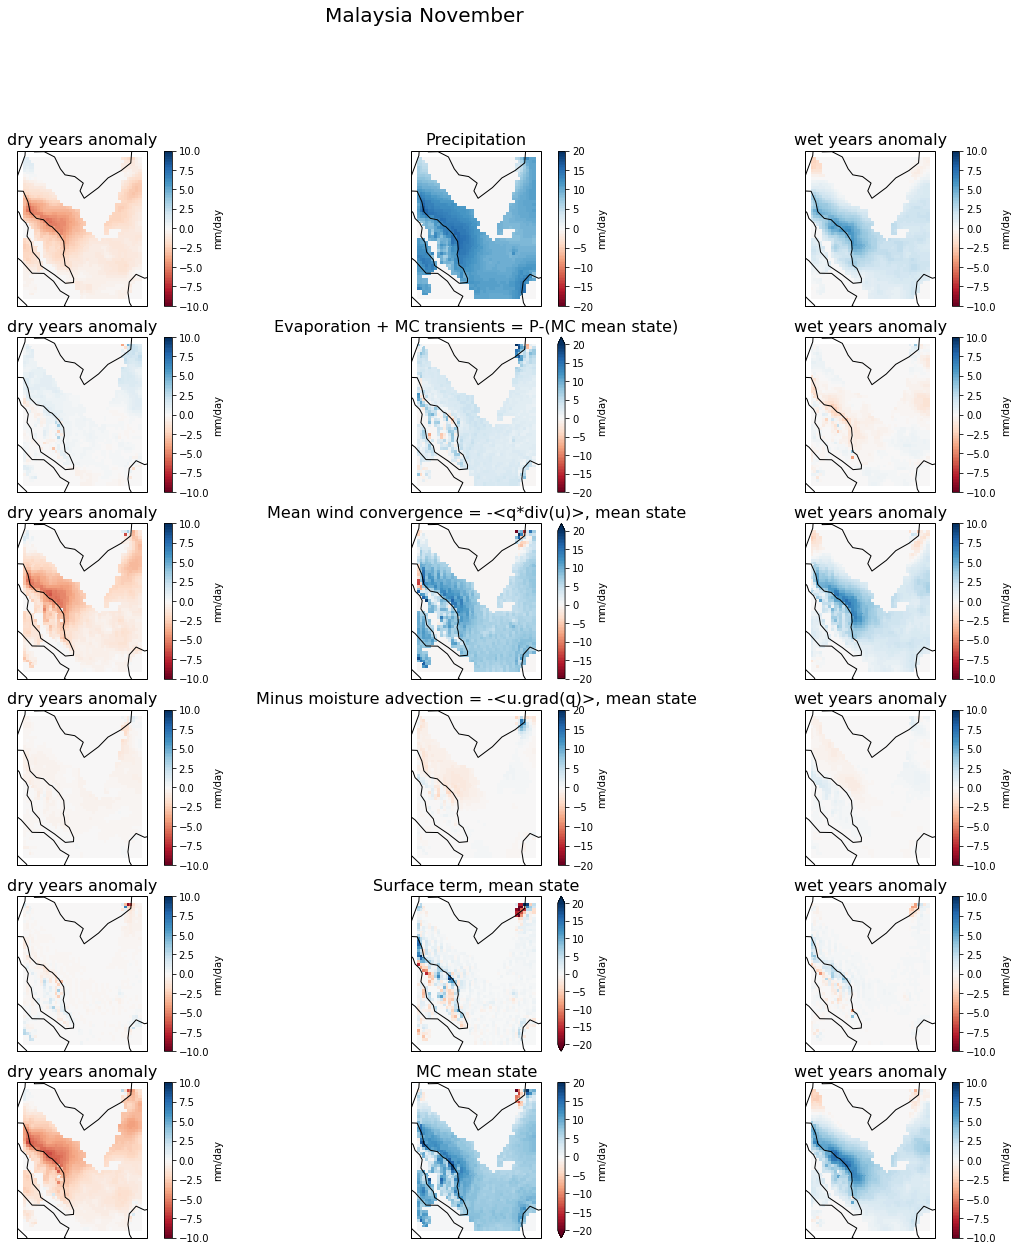

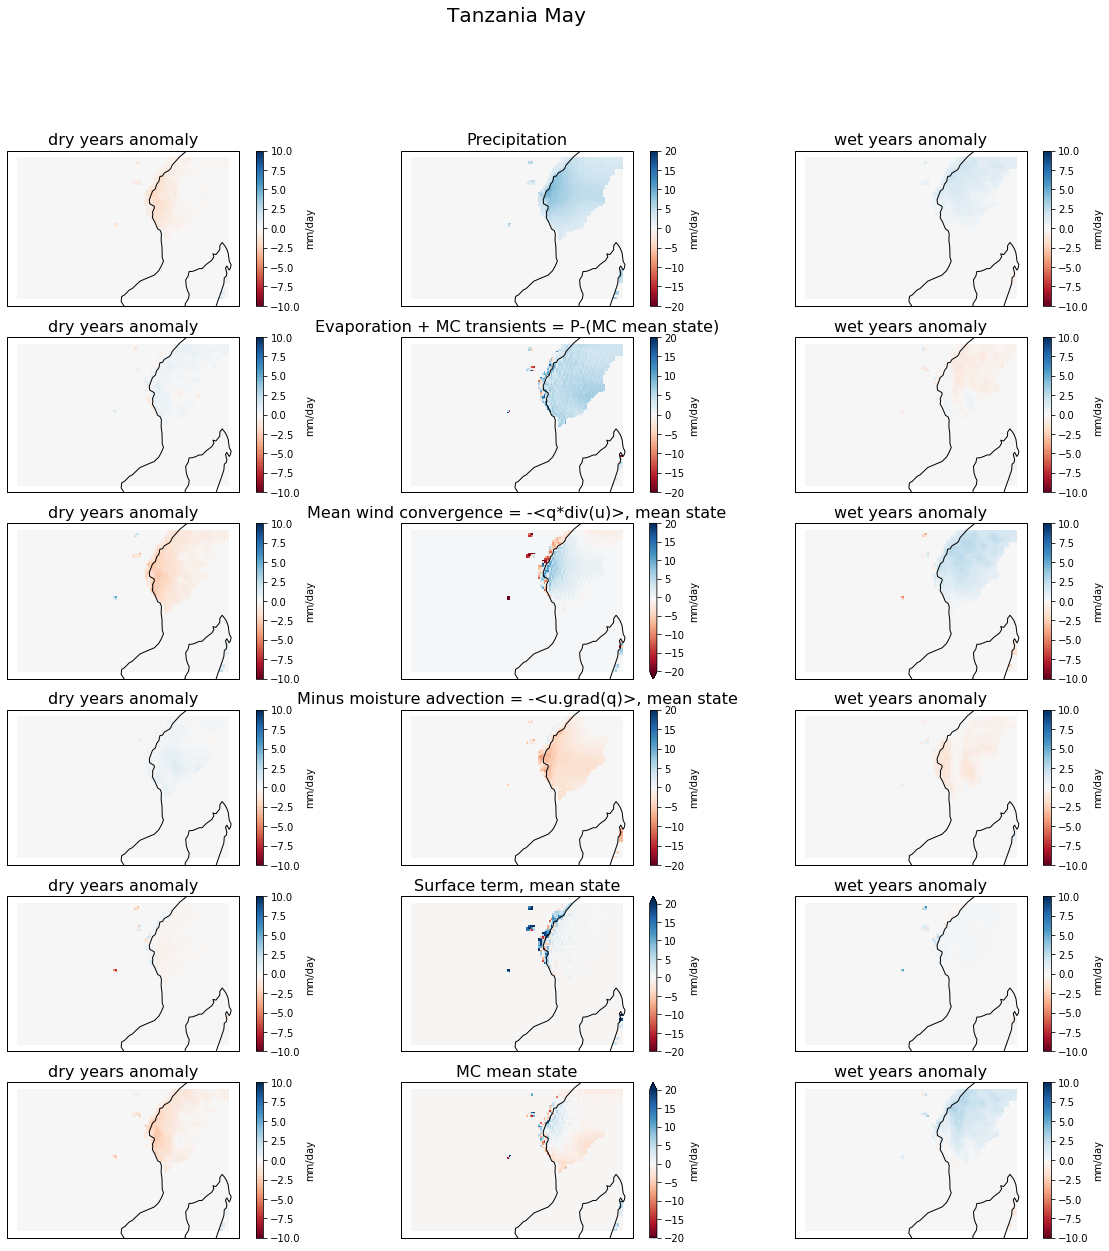

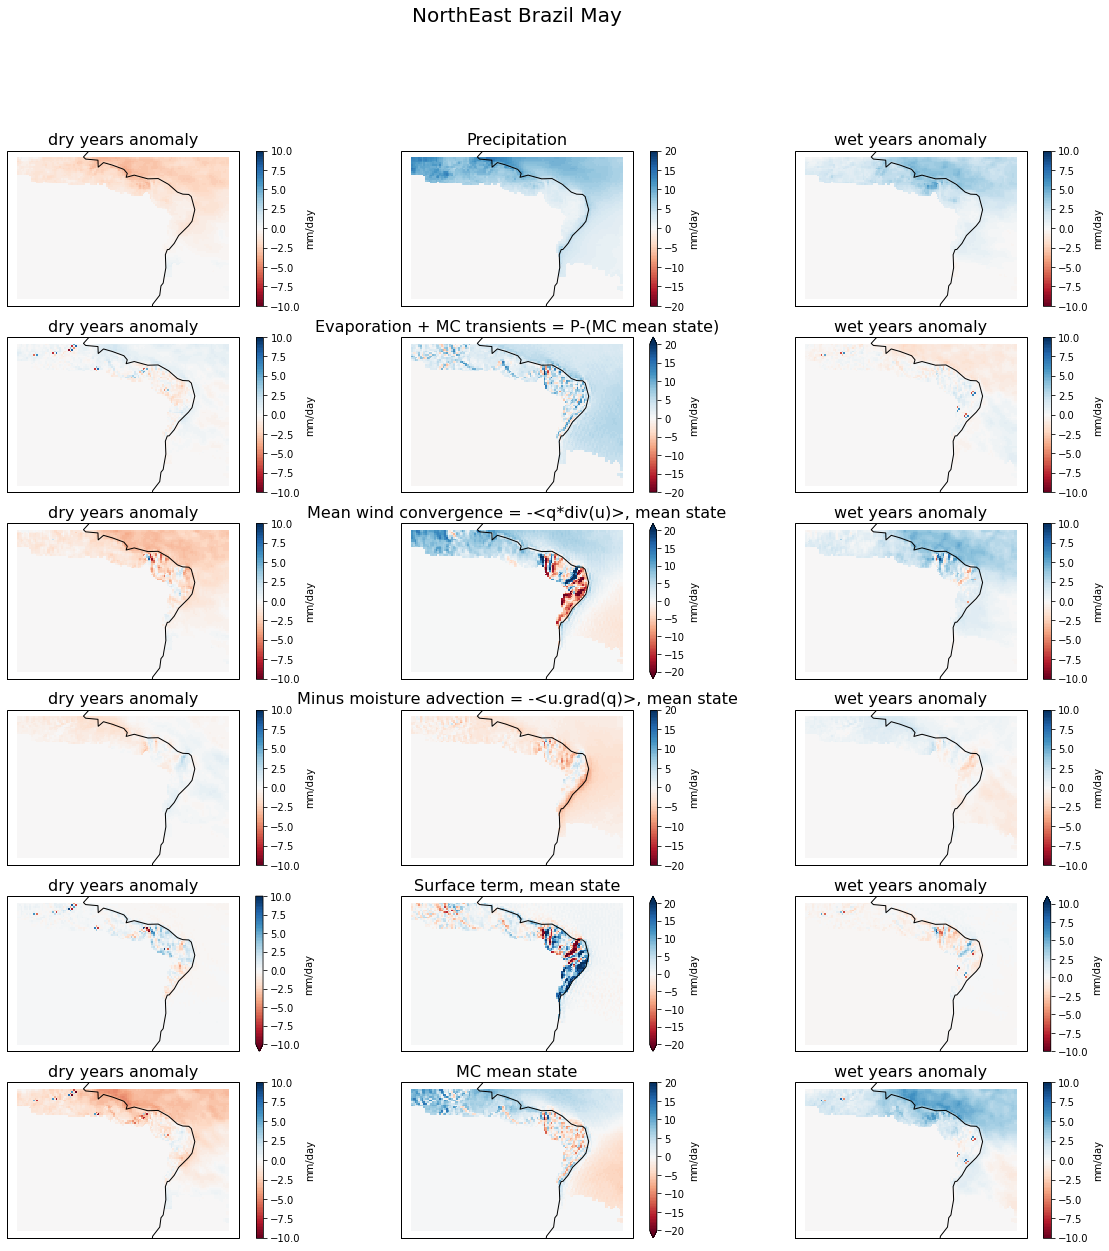

In [74]:
def plot_drywet(boxes,maskk,mean_pr,mc_tmean,conv_term,sfc_term,adv_term,pr_wd,mccc_wd,conv_wd,sfcc_wd,advv_wd,month,names ):
    for i,box in enumerate(boxes):
        mask = maskk.sel(longitude=slice(box[0],box[1]),latitude=slice(box[3],box[2]))
        
        #Mean state values
        prrr = mask*  mean_pr.sel(longitude=slice(box[0],box[1]),latitude=slice(box[3],box[2]))
        mccc = mask* mc_tmean.sel(longitude=slice(box[0],box[1]),latitude=slice(box[3],box[2]))
        conv = mask*conv_term.sel(longitude=slice(box[0],box[1]),latitude=slice(box[3],box[2]))
        surf = mask* sfc_term.sel(longitude=slice(box[0],box[1]),latitude=slice(box[3],box[2]))
        advv = mask* adv_term.sel(longitude=slice(box[0],box[1]),latitude=slice(box[3],box[2]))
        evap = prrr-mccc
        
        #dry years values
        prrr_d = mask*  pr_wd[i]["dry"].sel(longitude=slice(box[0],box[1]),latitude=slice(box[3],box[2]))
        mccc_d = mask*mccc_wd[i]["dry"].sel(longitude=slice(box[0],box[1]),latitude=slice(box[3],box[2]))
        conv_d = mask*conv_wd[i]["dry"].sel(longitude=slice(box[0],box[1]),latitude=slice(box[3],box[2]))
        surf_d = mask*sfcc_wd[i]["dry"].sel(longitude=slice(box[0],box[1]),latitude=slice(box[3],box[2]))
        advv_d = mask*advv_wd[i]["dry"].sel(longitude=slice(box[0],box[1]),latitude=slice(box[3],box[2]))
        evap_d = prrr_d-mccc_d
    
        #wet years values
        prrr_w = mask*  pr_wd[i]["wet"].sel(longitude=slice(box[0],box[1]),latitude=slice(box[3],box[2]))
        mccc_w = mask*mccc_wd[i]["wet"].sel(longitude=slice(box[0],box[1]),latitude=slice(box[3],box[2]))
        conv_w = mask*conv_wd[i]["wet"].sel(longitude=slice(box[0],box[1]),latitude=slice(box[3],box[2]))
        surf_w = mask*sfcc_wd[i]["wet"].sel(longitude=slice(box[0],box[1]),latitude=slice(box[3],box[2]))
        advv_w = mask*advv_wd[i]["wet"].sel(longitude=slice(box[0],box[1]),latitude=slice(box[3],box[2]))
        evap_w = prrr_w-mccc_w
        
        M = 20.
        m=10.
        fig, ax = plt.subplots(6,3,figsize=(20,20),subplot_kw={'projection': ccrs.PlateCarree()})
        prrr.plot(ax=ax[0][1],transform=ccrs.PlateCarree(),cmap=plt.cm.RdBu,cbar_kwargs={"label":"mm/day","ticks":np.arange(-M,M+1,M/4)},levels=np.linspace(-M,M,100))
        evap.plot(ax=ax[1][1],transform=ccrs.PlateCarree(),cmap=plt.cm.RdBu,cbar_kwargs={"label":"mm/day","ticks":np.arange(-M,M+1,M/4)},levels=np.linspace(-M,M,100))
        conv.plot(ax=ax[2][1],transform=ccrs.PlateCarree(),cmap=plt.cm.RdBu,cbar_kwargs={"label":"mm/day","ticks":np.arange(-M,M+1,M/4)},levels=np.linspace(-M,M,100))
        advv.plot(ax=ax[3][1],transform=ccrs.PlateCarree(),cmap=plt.cm.RdBu,cbar_kwargs={"label":"mm/day","ticks":np.arange(-M,M+1,M/4)},levels=np.linspace(-M,M,100))
        surf.plot(ax=ax[4][1],transform=ccrs.PlateCarree(),cmap=plt.cm.RdBu,cbar_kwargs={"label":"mm/day","ticks":np.arange(-M,M+1,M/4)},levels=np.linspace(-M,M,100))
        mccc.plot(ax=ax[5][1],transform=ccrs.PlateCarree(),cmap=plt.cm.RdBu,cbar_kwargs={"label":"mm/day","ticks":np.arange(-M,M+1,M/4)},levels=np.linspace(-M,M,100))
        
        (prrr_d - prrr).plot(ax=ax[0][0],transform=ccrs.PlateCarree(),cmap=plt.cm.RdBu,cbar_kwargs={"label":"mm/day","ticks":np.arange(-m,m+1,m/4)},levels=np.linspace(-m,m,100))
        (evap_d - evap).plot(ax=ax[1][0],transform=ccrs.PlateCarree(),cmap=plt.cm.RdBu,cbar_kwargs={"label":"mm/day","ticks":np.arange(-m,m+1,m/4)},levels=np.linspace(-m,m,100))
        (conv_d - conv).plot(ax=ax[2][0],transform=ccrs.PlateCarree(),cmap=plt.cm.RdBu,cbar_kwargs={"label":"mm/day","ticks":np.arange(-m,m+1,m/4)},levels=np.linspace(-m,m,100))
        (advv_d - advv).plot(ax=ax[3][0],transform=ccrs.PlateCarree(),cmap=plt.cm.RdBu,cbar_kwargs={"label":"mm/day","ticks":np.arange(-m,m+1,m/4)},levels=np.linspace(-m,m,100))
        (surf_d - surf).plot(ax=ax[4][0],transform=ccrs.PlateCarree(),cmap=plt.cm.RdBu,cbar_kwargs={"label":"mm/day","ticks":np.arange(-m,m+1,m/4)},levels=np.linspace(-m,m,100))
        (mccc_d - mccc).plot(ax=ax[5][0],transform=ccrs.PlateCarree(),cmap=plt.cm.RdBu,cbar_kwargs={"label":"mm/day","ticks":np.arange(-m,m+1,m/4)},levels=np.linspace(-m,m,100))
        (prrr_w - prrr).plot(ax=ax[0][2],transform=ccrs.PlateCarree(),cmap=plt.cm.RdBu,cbar_kwargs={"label":"mm/day","ticks":np.arange(-m,m+1,m/4)},levels=np.linspace(-m,m,100))
        (evap_w - evap).plot(ax=ax[1][2],transform=ccrs.PlateCarree(),cmap=plt.cm.RdBu,cbar_kwargs={"label":"mm/day","ticks":np.arange(-m,m+1,m/4)},levels=np.linspace(-m,m,100))
        (conv_w - conv).plot(ax=ax[2][2],transform=ccrs.PlateCarree(),cmap=plt.cm.RdBu,cbar_kwargs={"label":"mm/day","ticks":np.arange(-m,m+1,m/4)},levels=np.linspace(-m,m,100))
        (advv_w - advv).plot(ax=ax[3][2],transform=ccrs.PlateCarree(),cmap=plt.cm.RdBu,cbar_kwargs={"label":"mm/day","ticks":np.arange(-m,m+1,m/4)},levels=np.linspace(-m,m,100))
        (surf_w - surf).plot(ax=ax[4][2],transform=ccrs.PlateCarree(),cmap=plt.cm.RdBu,cbar_kwargs={"label":"mm/day","ticks":np.arange(-m,m+1,m/4)},levels=np.linspace(-m,m,100))
        (mccc_w - mccc).plot(ax=ax[5][2],transform=ccrs.PlateCarree(),cmap=plt.cm.RdBu,cbar_kwargs={"label":"mm/day","ticks":np.arange(-m,m+1,m/4)},levels=np.linspace(-m,m,100))
          
        titles = ["Precipitation","Evaporation + MC transients = P-(MC mean state)","Mean wind convergence = -<q*div(u)>, mean state","Minus moisture advection = -<u.grad(q)>, mean state","Surface term, mean state","MC mean state"]
        for j,a in enumerate(ax):
            for b in a:
                b.coastlines()
            a[1].set_title(titles[j],fontsize=16)
            a[0].set_title("dry years anomaly",fontsize=16)
            a[2].set_title("wet years anomaly",fontsize=16)
        fig.suptitle(names[i]+" %s"%month,fontsize=20)

plot_drywet(boxNH1,trmm_nh_winter_mask1,mean_pr_nov,mc_tmean_nov,conv_term_nov,sfc_term_nov,adv_term_nov,prNH,mcccNH,convNH,sfccNH,advvNH,"November",namesNH)
plot_drywet(boxSH1,trmm_sh_winter_mask1,mean_pr_may,mc_tmean_may,conv_term_may,sfc_term_may,adv_term_may,prSH,mcccSH,convSH,sfccSH,advvSH,"May",namesSH)

        

## Convergence term breakdown for dry vs wet years

In [82]:
convNH=[]; qp_divuNH =[]; q_divupNH =[]    
for i,box in enumerate(boxNH1):
    cod = compute_conv_term(qqNH[i]["dry"],wwNH[i]["dry"],psNH[i]["dry"])
    cow = compute_conv_term(qqNH[i]["wet"],wwNH[i]["wet"],psNH[i]["wet"])
    
    qp_divu_d = compute_conv_term(qqNH[i]["dry"],w_tmean_nov,psNH[i]["dry"])
    qp_divu_w = compute_conv_term(qqNH[i]["wet"],w_tmean_nov,psNH[i]["wet"])
    
    q_divup_d = compute_conv_term(q_tmean_nov,wwNH[i]["dry"],psNH[i]["dry"])
    q_divup_w = compute_conv_term(q_tmean_nov,wwNH[i]["wet"],psNH[i]["wet"])
    
    
    convNH.append({"dry" : cod, "wet" : cow}) 
    qp_divuNH.append({"dry" : qp_divu_d, "wet" : qp_divu_w}) 
    q_divupNH.append({"dry" : q_divup_d, "wet" : q_divup_w}) 


#mcccSH  =[]; convSH=[]; advvSH =[]; sfccSH =[]    
#for i,box in enumerate(boxSH1):
#    mcd,cod,add,sfd = compute_mc_terms(qqSH[i]["dry"],uuSH[i]["dry"],vvSH[i]["dry"],wwSH[i]["dry"],psSH[i]["dry"])
#    mcw,cow,adw,sfw = compute_mc_terms(qqSH[i]["wet"],uuSH[i]["wet"],vvSH[i]["wet"],wwSH[i]["wet"],psSH[i]["wet"])
#    mcccSH.append({"dry" : mcd, "wet" : mcw})
#    convSH.append({"dry" : cod, "wet" : cow}) 
#    advvSH.append({"dry" : add, "wet" : adw}) 
#    sfccSH.append({"dry" : sfd, "wet" : sfw}) 
#

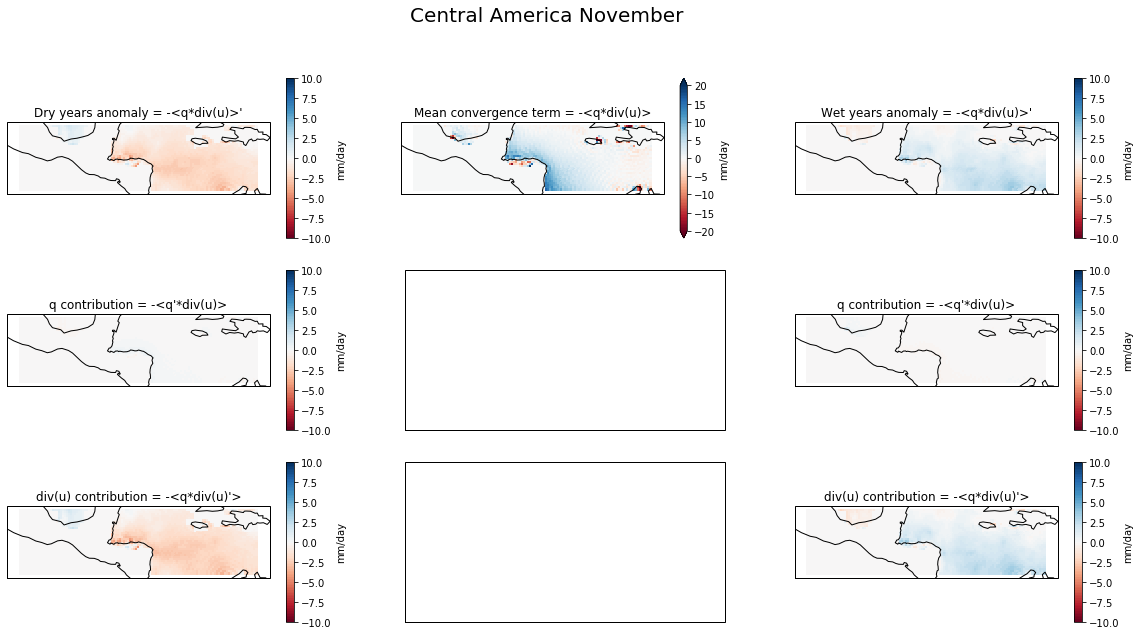

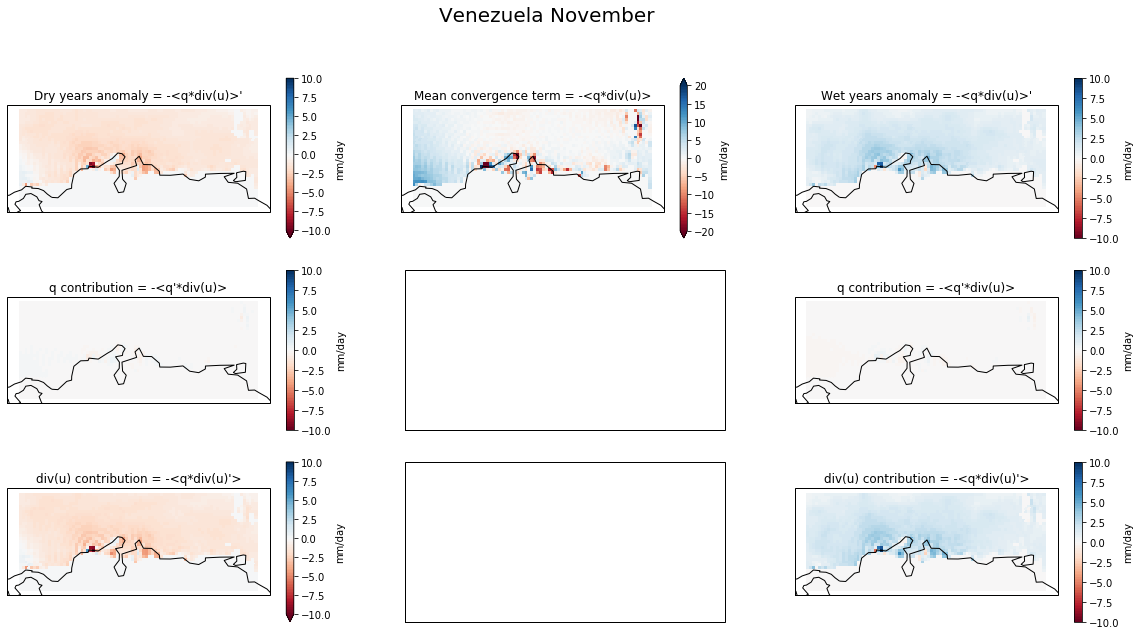

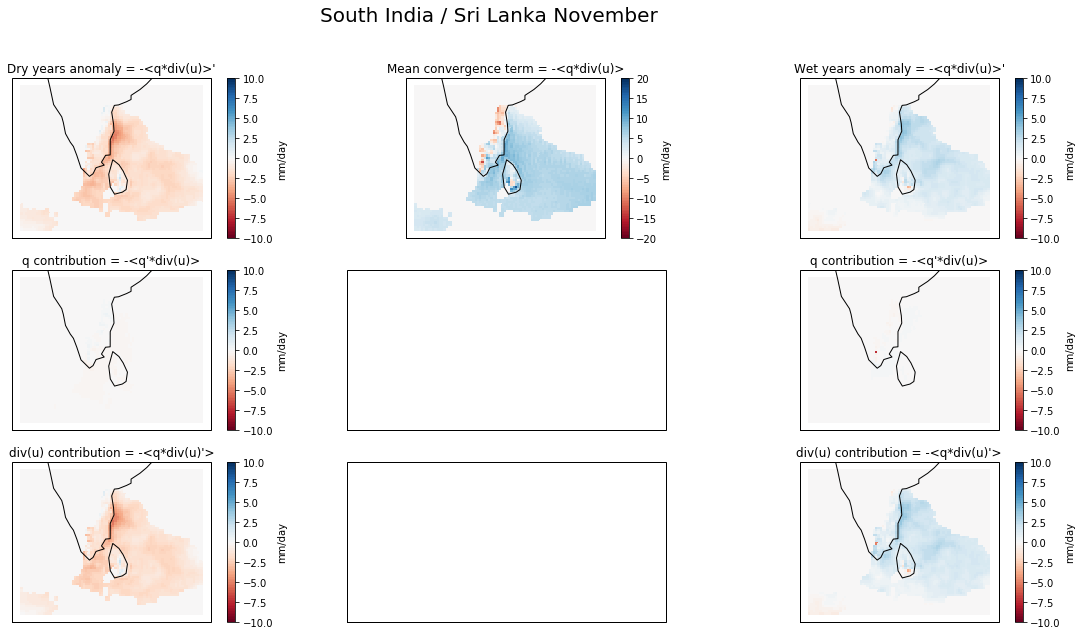

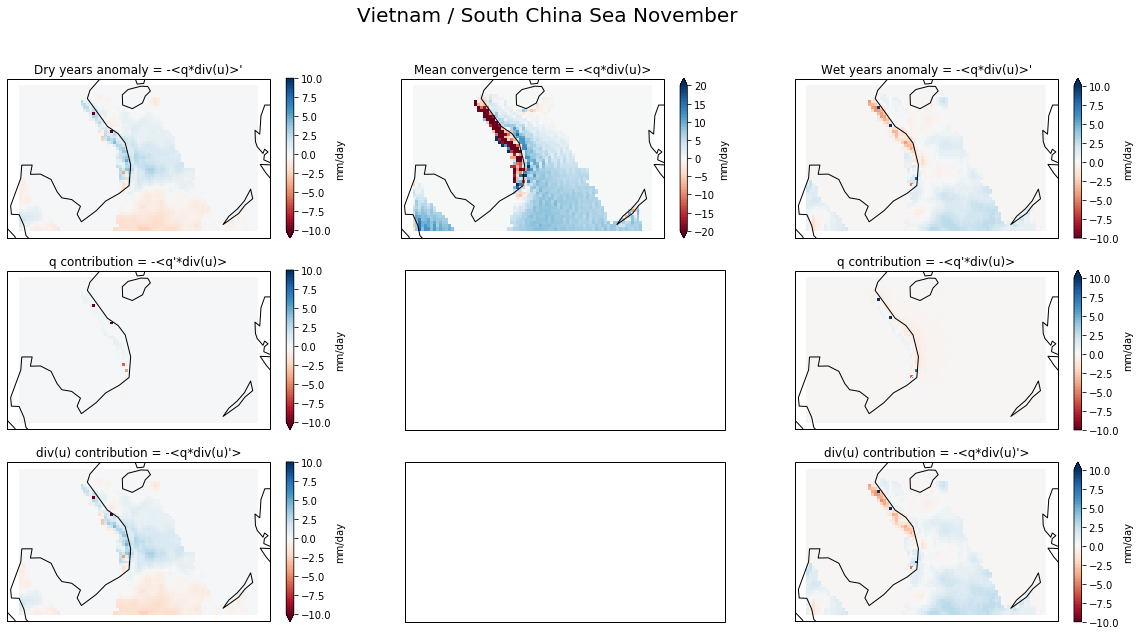

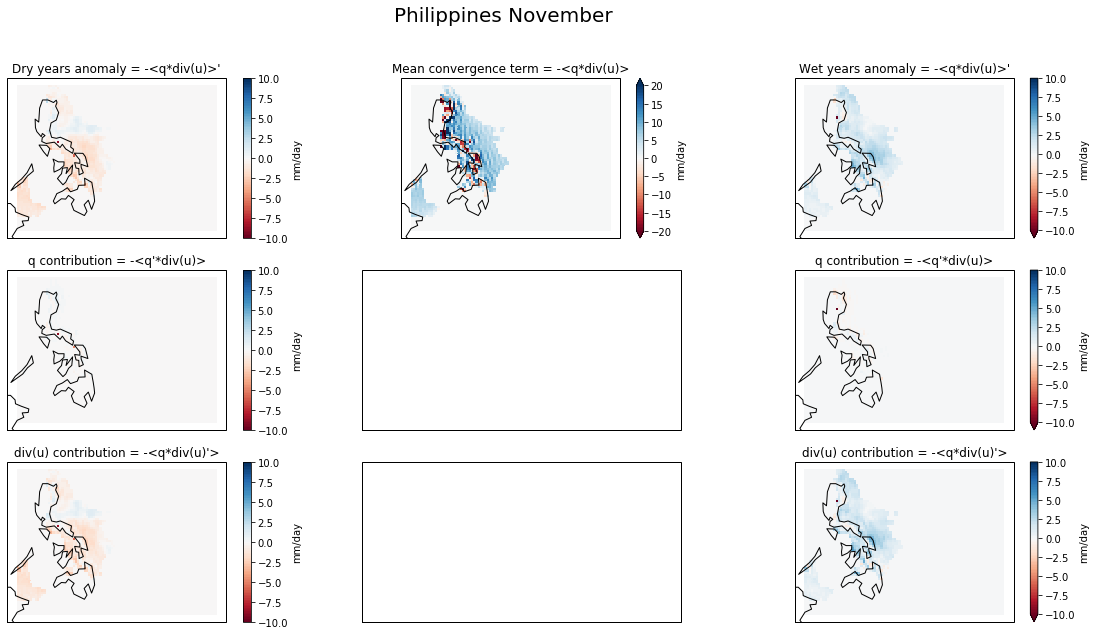

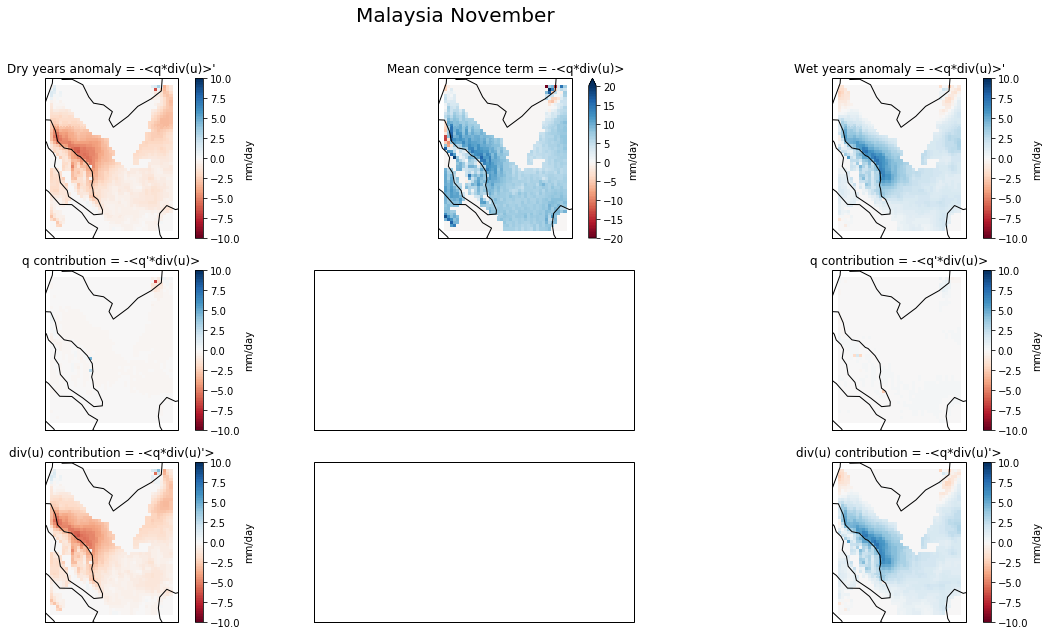

In [88]:
def plot_drywet_convterm(boxes,maskk,conv_term,conv_wd,qp_divu_wd,q_divup_wd,month,names ):
    for i,box in enumerate(boxes):
        mask = maskk.sel(longitude=slice(box[0],box[1]),latitude=slice(box[3],box[2]))
        
        conv = mask*conv_term.sel(longitude=slice(box[0],box[1]),latitude=slice(box[3],box[2]))
        conv_d = mask*conv_wd[i]["dry"].sel(longitude=slice(box[0],box[1]),latitude=slice(box[3],box[2]))
        conv_w = mask*conv_wd[i]["wet"].sel(longitude=slice(box[0],box[1]),latitude=slice(box[3],box[2]))
        qp_divu_d = mask*qp_divu_wd[i]["dry"].sel(longitude=slice(box[0],box[1]),latitude=slice(box[3],box[2]))
        qp_divu_w = mask*qp_divu_wd[i]["wet"].sel(longitude=slice(box[0],box[1]),latitude=slice(box[3],box[2]))
        q_divup_d = mask*q_divup_wd[i]["dry"].sel(longitude=slice(box[0],box[1]),latitude=slice(box[3],box[2]))
        q_divup_w = mask*q_divup_wd[i]["wet"].sel(longitude=slice(box[0],box[1]),latitude=slice(box[3],box[2]))

        
        M = 20.
        m=10.
        fig, ax = plt.subplots(3,3,figsize=(20,10),subplot_kw={'projection': ccrs.PlateCarree()})
        conv.plot(ax=ax[0][1],transform=ccrs.PlateCarree(),cmap=plt.cm.RdBu,cbar_kwargs={"label":"mm/day","ticks":np.arange(-M,M+1,M/4)},levels=np.linspace(-M,M,100))

        (conv_d - conv).plot(ax=ax[0][0],transform=ccrs.PlateCarree(),cmap=plt.cm.RdBu,cbar_kwargs={"label":"mm/day","ticks":np.arange(-m,m+1,m/4)},levels=np.linspace(-m,m,100))
        (conv_w - conv).plot(ax=ax[0][2],transform=ccrs.PlateCarree(),cmap=plt.cm.RdBu,cbar_kwargs={"label":"mm/day","ticks":np.arange(-m,m+1,m/4)},levels=np.linspace(-m,m,100))
 
        (qp_divu_d - conv).plot(ax=ax[1][0],transform=ccrs.PlateCarree(),cmap=plt.cm.RdBu,cbar_kwargs={"label":"mm/day","ticks":np.arange(-m,m+1,m/4)},levels=np.linspace(-m,m,100))
        (qp_divu_w - conv).plot(ax=ax[1][2],transform=ccrs.PlateCarree(),cmap=plt.cm.RdBu,cbar_kwargs={"label":"mm/day","ticks":np.arange(-m,m+1,m/4)},levels=np.linspace(-m,m,100))
        (q_divup_d - conv).plot(ax=ax[2][0],transform=ccrs.PlateCarree(),cmap=plt.cm.RdBu,cbar_kwargs={"label":"mm/day","ticks":np.arange(-m,m+1,m/4)},levels=np.linspace(-m,m,100))
        (q_divup_w - conv).plot(ax=ax[2][2],transform=ccrs.PlateCarree(),cmap=plt.cm.RdBu,cbar_kwargs={"label":"mm/day","ticks":np.arange(-m,m+1,m/4)},levels=np.linspace(-m,m,100))
  
        ax[0][1].set_title("Mean convergence term = -<q*div(u)>"); ax[0][1].coastlines()
        ax[0][0].set_title("Dry years anomaly = -<q*div(u)>'")   ; ax[0][0].coastlines()
        ax[0][2].set_title("Wet years anomaly = -<q*div(u)>'")   ; ax[0][2].coastlines()
        ax[1][0].set_title("q contribution = -<q'*div(u)>")      ; ax[1][0].coastlines()  
        ax[1][2].set_title("q contribution = -<q'*div(u)>")      ; ax[1][2].coastlines()
        ax[2][0].set_title("div(u) contribution = -<q*div(u)'>") ; ax[2][0].coastlines()
        ax[2][2].set_title("div(u) contribution = -<q*div(u)'>") ; ax[2][2].coastlines()
        #for j,a in enumerate(ax):
        #    for b in a:
        #        b.coastlines()
        fig.suptitle(names[i]+" %s"%month,fontsize=20)

plot_drywet_convterm(boxNH1,trmm_nh_winter_mask1,conv_term_nov,convNH,qp_divuNH,q_divupNH,"November",namesNH)
#plot_drywet_convterm(boxSH1,trmm_sh_winter_mask1,conv_term_may,convSH,"May",namesSH)

        

# Vertical profiles of $\omega$ over land

In [16]:
def plot_vprofile_omega(omega,conv,mask,box,title=""):
    vprof = region_mean2D(omega,mask,box)
    dwdp = 1e4 * vprof.differentiate("level",edge_order=2)/100
    
    fig = plt.figure(figsize=(15,5))
    ax1 = fig.add_subplot(121)
    ax1.plot(vprof,vprof.level ,label="omega")
    ax1.plot(dwdp,dwdp.level   ,label=" - div u = d omega / dp , mean = %.2e s^-1"%(dwdp.mean("level")/1e4))
    ax1.axvline(0,linestyle='--',color="k")
    ax1.set_xlabel("omega (Pa/s) | d omega / dp (10^-4 s^-1)")
    ax1.set_ylabel("pressure level (hPa)")
    ax1.set_ylim(1010, 0)
    ax1.set_title(title,fontsize=16)
    ax1.legend(loc='upper left')
    
    ax2 = fig.add_subplot(122,projection=ccrs.PlateCarree())
    convm = mask*conv.sel(longitude=slice(box[0],box[1]),latitude=slice(box[3],box[2]))
    convm.plot(ax=ax2,transform=ccrs.PlateCarree(),cmap=plt.cm.RdBu,cbar_kwargs={"label":"mm/day","ticks":np.arange(-8.,10.,2.)},levels=np.linspace(-10.,10.,100))
    ax2.coastlines()
    ax2.set_title("Mean wind convergence = -<q*div(u)>, mean = %.2f mm/day"%(convm.mean(["latitude","longitude"])),fontsize=16)
    

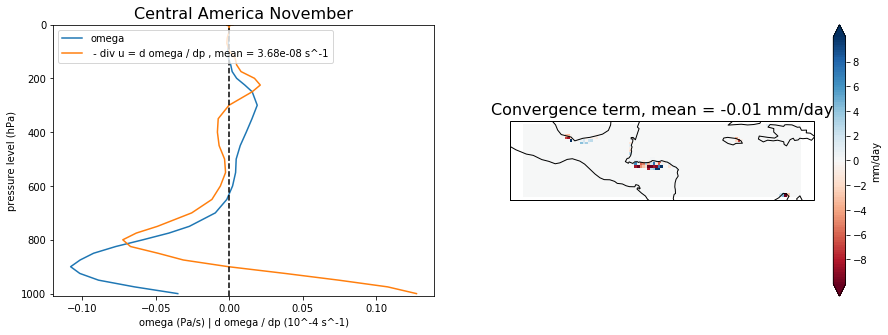

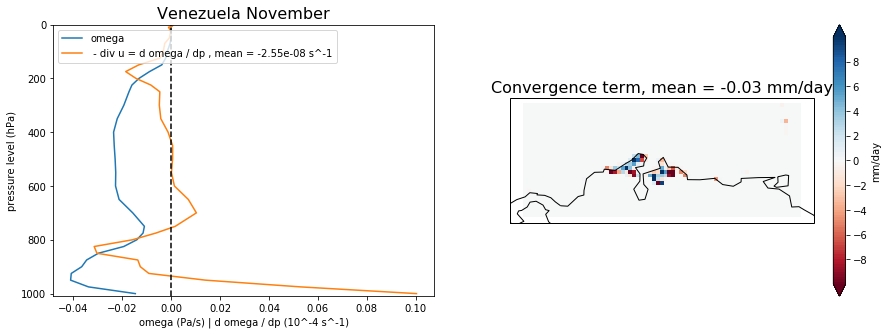

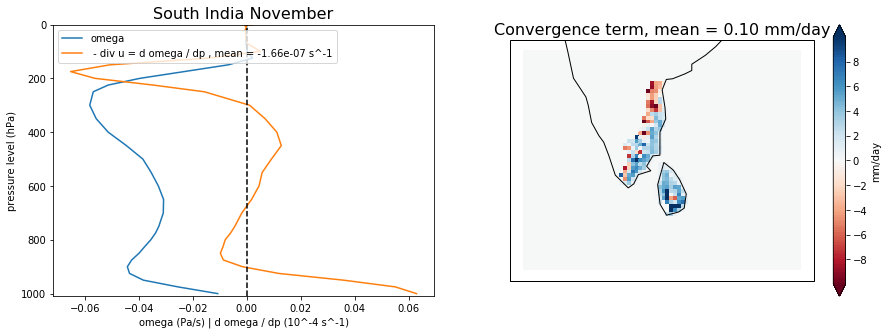

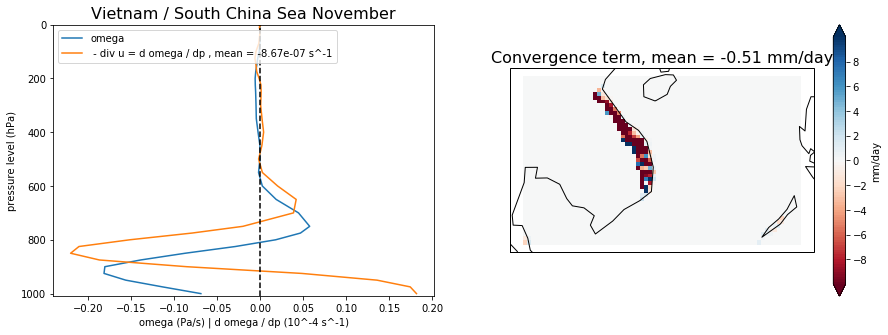

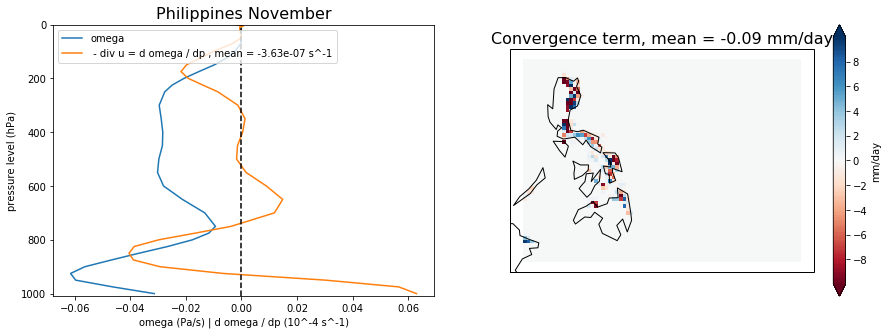

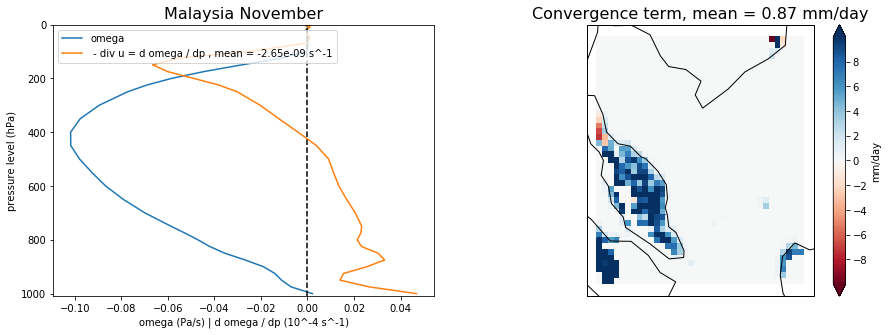

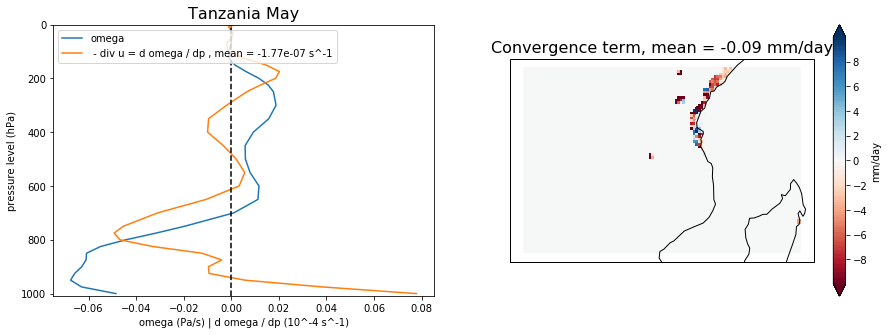

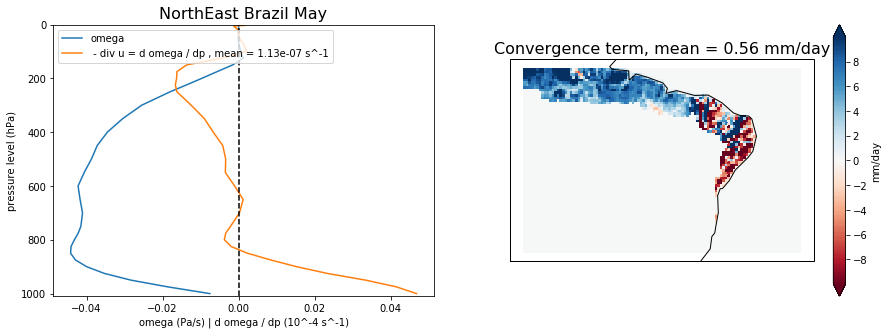

In [26]:
for i,box in enumerate(boxNH1):
    plot_vprofile_omega(w_tmean_nov, conv_term_nov*landmask50, trmm_nh_winter_mask1*landmask50,box,namesNH[i]+" November")
for i,box in enumerate(boxSH1):
    plot_vprofile_omega(w_tmean_may, conv_term_may*landmask50, trmm_sh_winter_mask1*landmask50,box,namesSH[i]+" May")

#for i,box in enumerate(boxNH1):
#    plot_vprofile_omega(w_tmean_nov, conv_term_nov, trmm_nh_winter_mask1,box,namesNH[i]+" November")
#for i,box in enumerate(boxSH1):
#    plot_vprofile_omega(w_tmean_may, conv_term_may, trmm_sh_winter_mask1,box,namesSH[i]+" May")

79

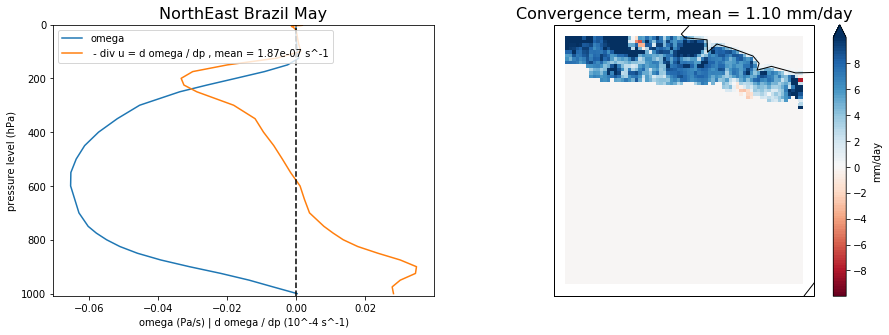

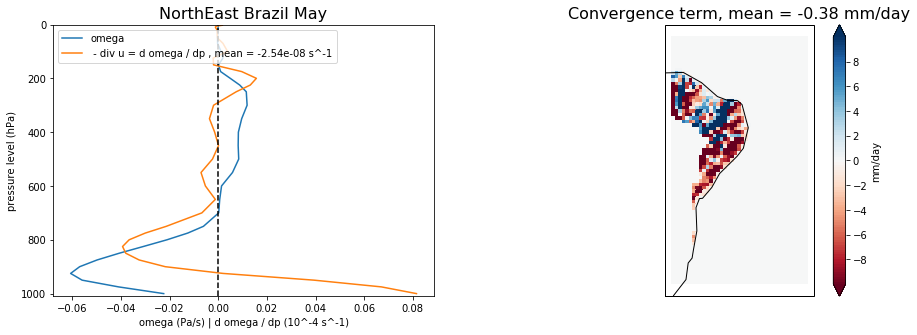

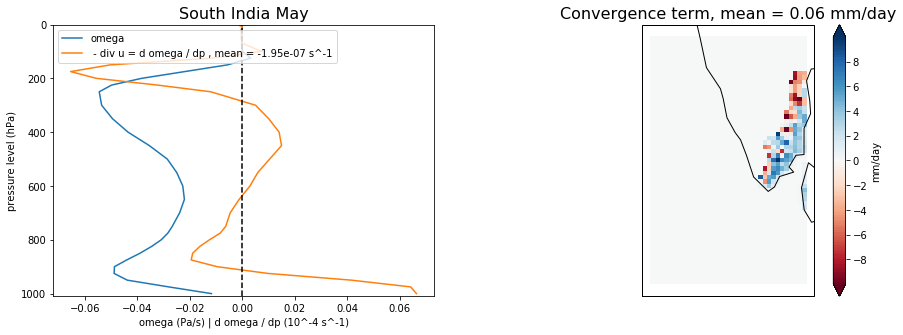

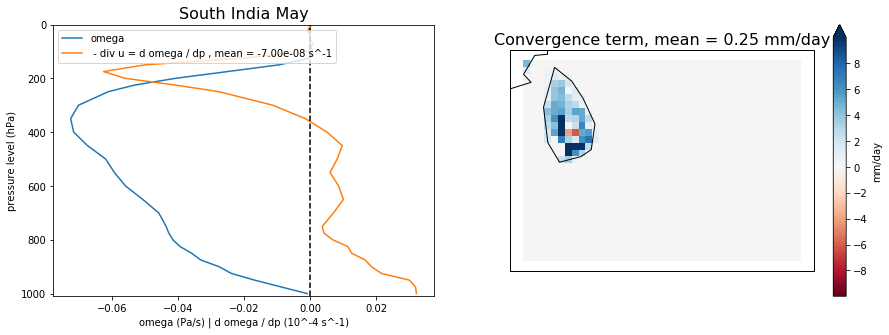

In [25]:
#split brazil into 2 regions
b = boxSH1[1]
b1 = b.copy();b2 = b.copy();
b1[1]=319.;b2[0]=319.;
plot_vprofile_omega(w_tmean_may, conv_term_may*landmask50, trmm_sh_winter_mask1*landmask50,b1,namesSH[1]+" May")
plot_vprofile_omega(w_tmean_may, conv_term_may*landmask50, trmm_sh_winter_mask1*landmask50,b2,namesSH[1]+" May")

#split south asia into 2 regions
b = boxNH1[2]
b1 = b.copy();b2 = b.copy();
b1[1]=80.;b2[0]=79.;b2[3]=10.;
plot_vprofile_omega(w_tmean_nov, conv_term_nov*landmask50, trmm_nh_winter_mask1*landmask50,b1,namesNH[2]+" May")
plot_vprofile_omega(w_tmean_nov, conv_term_nov*landmask50, trmm_nh_winter_mask1*landmask50,b2,namesNH[2]+" May")
79


# Vertical profile over vietnam for rainy days only

In [28]:
def region_mean2Dtrmm(variable,mask,box):
    """Given a 2D variable (lat, lon), compute a spatial mean within a specified region
    defined by a mask, inside a given box
        - variable = 3D xarray.dataarray. Dimensions must be named "latitude" and "longitude"
        - mask = 2D xarray.dataarray of 0s and 1s. Must have same grid and dimension names as 'variable'
        - box = list of four items, [lon1, lon2, lat1, lat2]
    """
    mask_box = mask.sel(lon=slice(box[0],box[1]),lat=slice(box[2],box[3]))
    variable_box = variable.sel(lon=slice(box[0],box[1]),lat=slice(box[2],box[3]))
    maskedvar = variable_box*mask_box
    region_mean = maskedvar.fillna(0).sum(["lat","lon"])/ mask_box.sum(["lat","lon"])
    
    return region_mean

def concat_pr_trmm(lonlat,mnth):
    """returns an array containg the daily precipitation, in mm, in a given box, 
    for all days in a given month between 01/2010 and 12/2012 """
    
    allfiles = glob.glob("/global/cfs/projectdirs/m3522/cmip6/obs4mip/NASA-GSFC/TRMM/observations/atmos/pr/3hr/NASA-GSFC/TRMM/*/*_20??%s*"%mnth)
    allfiles.sort(key = lambda l : l[-28:-16])
    
    allpr=[]
    t=time.time()

    for filename in allfiles :
        if "201012311930" in filename:
            continue
        print(os.path.basename(filename))
        pr = xr.open_dataset(filename)
        pr_limited = pr.sel(lon=slice(lonlat[0],lonlat[1]),lat=slice(lonlat[2],lonlat[3])).pr
        pr_resampled = pr_limited.resample(time="1D").mean(dim="time")*24*3600
        allpr.append(pr_resampled)
    print(time.time()-t)
    return xr.concat(allpr,"time")

pr_vietnam_2010_2013 = concat_pr_trmm(boxNH1[3],"11")

pr_TRMM-L3_v7A_200011010130-200011302230.nc
pr_TRMM-L3_v7A_200111010130-200111302230.nc
pr_TRMM-L3_v7A_200211010130-200211302230.nc
pr_TRMM-L3_v7A_200311010130-200311302230.nc
pr_TRMM-L3_v7A_200411010130-200411302230.nc
pr_TRMM-L3_v7A_200511010130-200511302230.nc
pr_TRMM-L3_v7A_200611010130-200611302230.nc
pr_TRMM-L3_v7A_200711010130-200711302230.nc
pr_TRMM-L3_v7A_200811010130-200811302230.nc
pr_TRMM-L3_v7A_200911010130-200911302230.nc
pr_TRMM-L3_v7_201011010130-201011302230.nc
pr_TRMM-L3_v7_201111010130-201111302230.nc
pr_TRMM-L3_v7_201211010130-201211302230.nc
pr_TRMM-L3_v7_201311010130-201311302230.nc
2.763329267501831


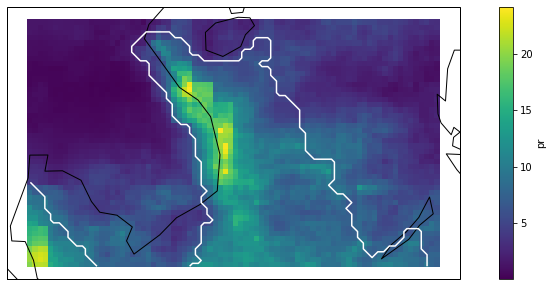

In [55]:
fig = plt.figure(figsize=(14,5)); ax = fig.add_subplot(projection= ccrs.PlateCarree());ax.coastlines()
pr_vietnam_2010_2013.mean("time").plot(ax=ax,transform=ccrs.PlateCarree())
ax.set_title("Vietnam mean november precip, TRMM, 2010-2013")
lonlat=boxNH1[3]
trmm_nh_winter_mask1.sel(longitude=slice(lonlat[0],lonlat[1]),latitude=slice(lonlat[3],lonlat[2])).plot.contour(ax=ax,transform=ccrs.PlateCarree(),**{'levels':[0.5], 'colors':['w']})



Mean : 9.7 mm/day | sd : 8.5 mm/day | Minimum : 0.0 mm/day | Maximum : 45.1 mm/day


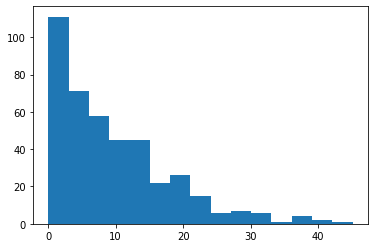

In [32]:
pr_vietnam_2010_2013_daily=region_mean2Dtrmm(pr_vietnam_2010_2013,trmm_nh_winter_mask.rename({'LAT1': 'lat','LON1': 'lon'}),boxNH1[3])

print("Mean : %.1f mm/day |"%pr_vietnam_2010_2013_daily.mean("time"),"sd : %.1f mm/day |"%pr_vietnam_2010_2013_daily.std("time"),
      "Minimum : %.1f mm/day |"%pr_vietnam_2010_2013_daily.min("time"),"Maximum : %.1f mm/day"%pr_vietnam_2010_2013_daily.max("time"))
plt.hist(pr_vietnam_2010_2013_daily, bins = 15, label="distribution of daily precip")
None

In [39]:
print(np.array([datetime.strftime(pd.to_datetime(d),format="%Y-%m-%d") for d in np.array(pr_vietnam_2010_2013_daily.time[np.array(np.argsort(pr_vietnam_2010_2013_daily)[-20:])])]))

np.array(pr_vietnam_2010_2013_daily[np.array(np.argsort(pr_vietnam_2010_2013_daily)[-20:])])
#np.argpartition(pr_vietnam_2010_2013_daily,10)[:10]

['2002-11-03' '2001-11-21' '2004-11-25' '2008-11-27' '2013-11-15'
 '2012-11-14' '2013-11-21' '2010-11-03' '2000-11-16' '2000-11-15'
 '2001-11-10' '2009-11-02' '2010-11-09' '2007-11-21' '2007-11-22'
 '2003-11-12' '2011-11-06' '2005-11-01' '2001-11-11' '2011-11-07']


array([27.37424803, 27.52744148, 27.79002432, 28.24153756, 29.48331883,
       29.68877562, 30.76656136, 30.80806516, 31.01085713, 31.76812278,
       32.80984155, 33.06766966, 33.35446939, 36.31285641, 36.9290039 ,
       38.06920509, 38.83155285, 39.71206697, 40.22812031, 45.12506752])

In [142]:
vietnam_rainy_days = pr_vietnam_2010_2013_daily.where(pr_vietnam_2010_2013_daily>float(pr_vietnam_2010_2013_daily.quantile(0.5,"time")),drop=True).time
ds = [datetime.strftime(pd.to_datetime(d),format="%Y%m%d") for d in np.array(vietnam_rainy_days)]

t=time.time()
q_vietnam_rainy_days = retrieve_era5_pl(ds,boxNH1[3],'128_133_q',firstlev=1,levdisc=1);print(time.time()-t)
u_vietnam_rainy_days = retrieve_era5_pl(ds,boxNH1[3],'128_131_u',firstlev=1,levdisc=1);print(time.time()-t)
v_vietnam_rainy_days = retrieve_era5_pl(ds,boxNH1[3],'128_132_v',firstlev=1,levdisc=1);print(time.time()-t)
w_vietnam_rainy_days = retrieve_era5_pl(ds,boxNH1[3],'128_135_w',firstlev=1,levdisc=1);print(time.time()-t)
ps_vietnam_rainy_days= retrieve_era5_sfc(ds,boxNH1[3],'128_134_sp');print(time.time()-t)
print("%i min"%((time.time()-t)/60))
#~20 min

298.17616844177246
599.8486249446869
923.1602001190186
1226.8651366233826
1237.1477885246277
20 min


In [143]:
def plot_vprofile_omega_2(omega,mask,box,title=""):
    vprof = region_mean2D(omega,mask,box)
    dwdp = 1e4 * vprof.differentiate("level",edge_order=2)/100
    
    fig = plt.figure(figsize=(7,5))
    ax1 = fig.add_subplot(111)
    ax1.plot(vprof,vprof.level ,label="omega")
    ax1.plot(dwdp,dwdp.level   ,label=" - div u = d omega / dp , mean = %.2e s^-1"%(dwdp.mean("level")/1e4))
    ax1.axvline(0,linestyle='--',color="k")
    ax1.set_xlabel("omega (Pa/s) | d omega / dp (10^-4 s^-1)")
    ax1.set_ylabel("pressure level (hPa)")
    ax1.set_ylim(1010, 0)
    ax1.set_title(title,fontsize=16)
    ax1.legend(loc='upper left')
    

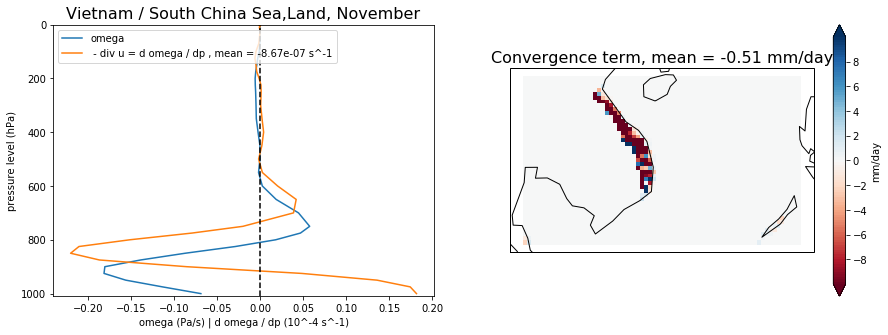

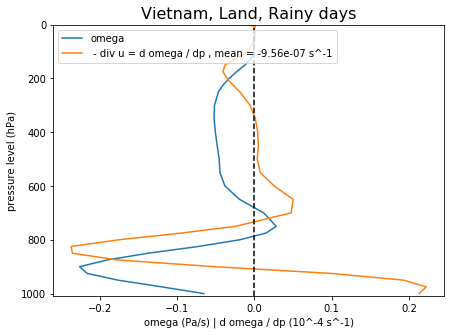

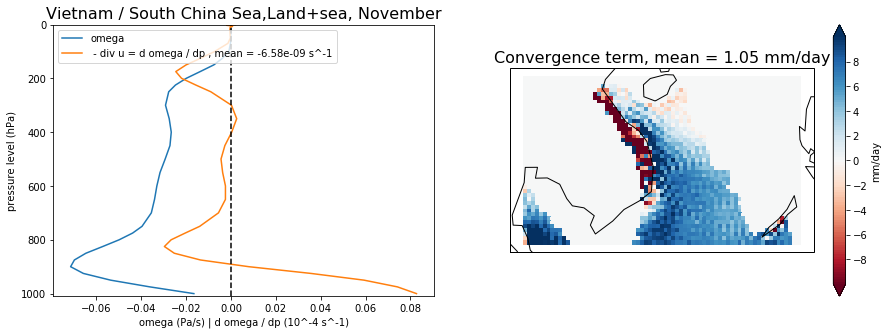

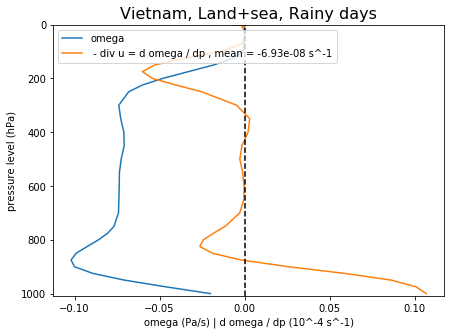

In [144]:
mean_omega_vietnam_rainy_days = omega_vietnam_rainy_days.mean(["time"])
plot_vprofile_omega(w_tmean_nov, conv_term_nov*landmask50, trmm_nh_winter_mask1*landmask50,boxNH1[3],namesNH[3]+",Land, November")
plot_vprofile_omega_2(mean_omega_vietnam_rainy_days.interp_like(REFERENCE_GRID),trmm_nh_winter_mask1*landmask50,boxNH1[3],title="Vietnam, Land, Rainy days")

plot_vprofile_omega(w_tmean_nov, conv_term_nov, trmm_nh_winter_mask1,boxNH1[3],namesNH[3]+",Land+sea, November")
plot_vprofile_omega_2(mean_omega_vietnam_rainy_days.interp_like(REFERENCE_GRID),trmm_nh_winter_mask1,boxNH1[3],title="Vietnam, Land+sea, Rainy days")



## Moisture convergence decomposition for rainy days

In [145]:
t=time.time()
mc_vietnam_rainy_days,conv_vietnam_rainy_days,adv_vietnam_rainy_days,sfc_vietnam_rainy_days = compute_mc_terms(q_vietnam_rainy_days,u_vietnam_rainy_days,v_vietnam_rainy_days,w_vietnam_rainy_days,ps_vietnam_rainy_days)
print("%i s"%(time.time()-t))

6 s


In [146]:
box=boxNH1[3]
mc_vietnam_rainy_days   = trmm_nh_winter_mask1.sel(longitude=slice(box[0],box[1]),latitude=slice(box[3],box[2]))*mc_vietnam_rainy_days.mean("time").interp_like(REFERENCE_GRID)
conv_vietnam_rainy_days = trmm_nh_winter_mask1.sel(longitude=slice(box[0],box[1]),latitude=slice(box[3],box[2]))*conv_vietnam_rainy_days.mean("time").interp_like(REFERENCE_GRID)
adv_vietnam_rainy_days  = trmm_nh_winter_mask1.sel(longitude=slice(box[0],box[1]),latitude=slice(box[3],box[2]))*adv_vietnam_rainy_days.mean("time").interp_like(REFERENCE_GRID)
sfc_vietnam_rainy_days  = trmm_nh_winter_mask1.sel(longitude=slice(box[0],box[1]),latitude=slice(box[3],box[2]))*sfc_vietnam_rainy_days.mean("time").interp_like(REFERENCE_GRID)

Text(0.5, 0.98, 'November')

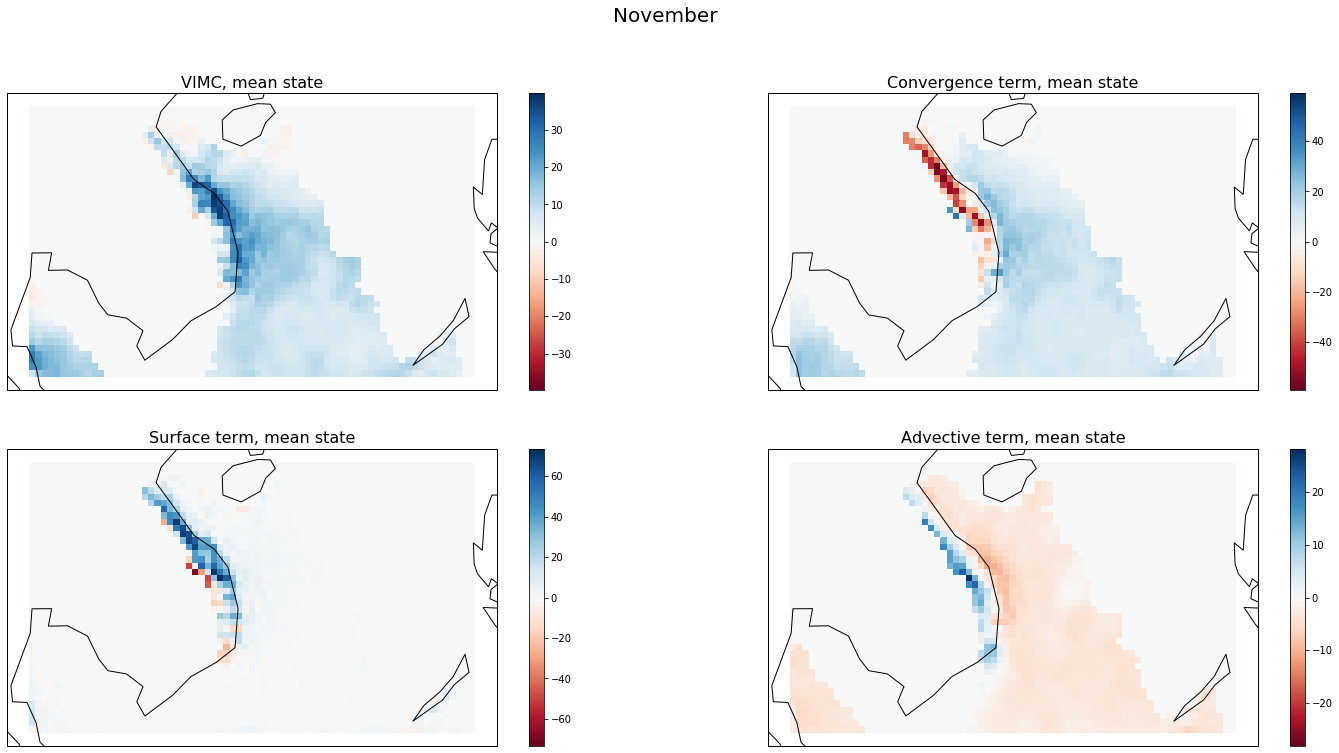

In [151]:
plot_limit=40.
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(25,12),subplot_kw={'projection': ccrs.PlateCarree()})
mc_vietnam_rainy_days.plot( ax=ax1,transform=ccrs.PlateCarree() ,cmap=plt.cm.RdBu)#,cbar_kwargs={"label":"mm/day","ticks":np.arange(-plot_limit,plot_limit+1,plot_limit/4)},levels=np.linspace(-plot_limit,plot_limit,100))
conv_vietnam_rainy_days.plot(ax=ax2,transform=ccrs.PlateCarree(),cmap=plt.cm.RdBu)#,cbar_kwargs={"label":"mm/day","ticks":np.arange(-plot_limit,plot_limit+1,plot_limit/4)},levels=np.linspace(-plot_limit,plot_limit,100))
sfc_vietnam_rainy_days.plot( ax=ax3,transform=ccrs.PlateCarree(),cmap=plt.cm.RdBu)#,cbar_kwargs={"label":"mm/day","ticks":np.arange(-plot_limit,plot_limit+1,plot_limit/4)},levels=np.linspace(-plot_limit,plot_limit,100))
adv_vietnam_rainy_days.plot( ax=ax4,transform=ccrs.PlateCarree(),cmap=plt.cm.RdBu)#,cbar_kwargs={"label":"mm/day","ticks":np.arange(-plot_limit,plot_limit+1,plot_limit/4)},levels=np.linspace(-plot_limit,plot_limit,100))
ax1.coastlines();ax2.coastlines();ax3.coastlines();ax4.coastlines()
ax1.set_title("VIMC, mean state",fontsize=16);ax2.set_title("Mean wind convergence = -<q*div(u)>, mean state",fontsize=16)
ax3.set_title("Surface term, mean state",fontsize=16);ax4.set_title("Minus moisture advection = -<u.grad(q)>, mean state",fontsize=16)

fig.suptitle("November",fontsize=20)

## Smith Orographic model over Vietnam ?

In [49]:
temp_tmean_nov = climat_mean("11",'128_130_t').sel(longitude=slice(lonlat2[0],lonlat2[1]),latitude=slice(lonlat2[3],lonlat2[2])).mean(["latitude","longitude"])
temp_tmean_nov

<xarray.DataArray 'T' (level: 37)>
array([262.9981 , 261.00784, 253.07036, 242.40547, 236.23117, 230.75601,
       222.03171, 215.85358, 206.76305, 196.673  , 190.71323, 197.16623,
       205.35028, 213.2967 , 220.57558, 227.12202, 233.0051 , 243.12978,
       251.38747, 258.1225 , 263.70242, 268.36118, 272.36197, 275.84924,
       279.44043, 282.68243, 285.47507, 286.7688 , 288.03003, 289.27588,
       290.52487, 291.78387, 293.05246, 294.29678, 295.51935, 297.0043 ,
       298.83798], dtype=float32)
Coordinates:
  * level    (level) float64 1.0 2.0 3.0 5.0 7.0 ... 925.0 950.0 975.0 1e+03

In [54]:
moist_adiabatic_lapse_rate(np.array([temp_surface]),np.array([ps]),'era')

array([0.00378865])

In [51]:
(temp_tmean_nov.sel(level=975) - temp_tmean_nov.sel(level=925))/(5000/(1.11*9.81))

<xarray.DataArray 'T' ()>
array(0.00589649)

In [40]:
from orographicPrecipitation.smith_lm import *
from orographicPrecipitation.precip_extremes_scaling import saturation_thermodynamics, moist_adiabatic_lapse_rate, pars

lonlat = boxNH1[3] #Vietnam box
lonlat2 = np.array(lonlat)+np.array([-1,1,-1,1]) #Do this to get rid of the border effects (high values of precip where the box crosses topography)

latitude = (lonlat[2]+lonlat[3])/2.

elevation = orog.sel(longitude=slice(lonlat2[0],lonlat2[1]),latitude=slice(lonlat2[3],lonlat2[2])).isel(time=0)
coslat = np.cos(np.array(elevation.latitude[0])*np.pi/180.)
dx = coslat*m_per_degreelat*np.abs(np.array(elevation.latitude[1]-elevation.latitude[0]))
dy = m_per_degreelat*np.abs(np.array(elevation.longitude[1]-elevation.longitude[0])) 

u900 = u_tmean_nov.sel(level=950.,longitude=slice(lonlat2[0],lonlat2[1]),latitude=slice(lonlat2[3],lonlat2[2])).mean(["latitude","longitude"])
v900 = v_tmean_nov.sel(level=950.,longitude=slice(lonlat2[0],lonlat2[1]),latitude=slice(lonlat2[3],lonlat2[2])).mean(["latitude","longitude"])
ps = ps_tmean_nov.sel(longitude=slice(lonlat2[0],lonlat2[1]),latitude=slice(lonlat2[3],lonlat2[2])).mean(["latitude","longitude"])
temps_tmean_nov = climat_mean("11",'128_167_2t')
temp_surface = temps_tmean_nov.sel(longitude=slice(lonlat2[0],lonlat2[1]),latitude=slice(lonlat2[3],lonlat2[2])).mean(["latitude","longitude"])


prsmith = linear_model_saturated(np.array([temp_surface]),np.array([ps]),np.array([u900]),np.array([v900]),latitude,elevation,dx,dy,lr_param=0.6)


Text(0.5, 0.98, 'Vietnam November')

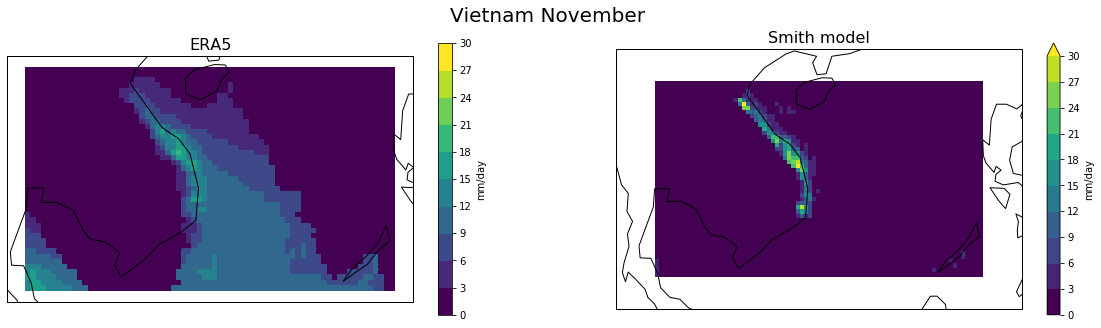

In [41]:
plot_limit=30.

box = boxNH1[3]
mask = trmm_nh_winter_mask1.sel(longitude=slice(box[0],box[1]),latitude=slice(box[3],box[2]))
prvietnam = mean_pr_nov.sel(longitude=slice(box[0],box[1]),latitude=slice(box[3],box[2]))

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,5),subplot_kw={'projection': ccrs.PlateCarree()})

(mask*prvietnam).plot(ax=ax1,transform=ccrs.PlateCarree(),cbar_kwargs={"label":"mm/day","ticks":np.arange(0,plot_limit+1,plot_limit/10)},levels=np.linspace(0,plot_limit,11))
(mask.interp_like(prsmith)*prsmith).plot(  ax=ax2,transform=ccrs.PlateCarree(),cbar_kwargs={"label":"mm/day","ticks":np.arange(0,plot_limit+1,plot_limit/10)},levels=np.linspace(0,plot_limit,11))

ax1.coastlines();ax2.coastlines()
ax1.set_title("ERA5",fontsize=16);ax2.set_title("Smith model",fontsize=16)

fig.suptitle("Vietnam November",fontsize=20)